In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import scipy as sp
import gym
from sklearn.kernel_approximation import RBFSampler

# **REINFORCEMENT LEARNING**

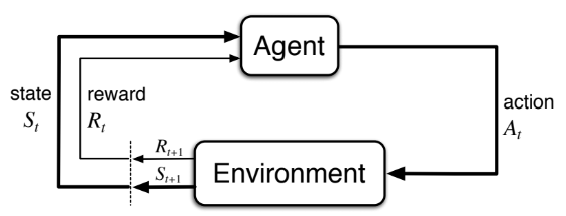



* Unlike multi-armed bandits, in RL, the states are non-stationary. This means that, for every action taken by the agent, the environment transitions to a different state.
* RL is active, goal-directed learning, without examples of optimal behaviour. Behaviour is learned by, often sequential, interactions with our environment, and by optimising a reward signal.
* The goal of the RL agent is to maximise the total expected reward, for every state, by picking suitable actions.

---

**Key Terms to remember in RL:**

1. Agent and the Environment 
1. State Space, $\mathcal{S}$ and Action Space, $\mathcal{A}$ 
1. What is an Episode, and its Terminal state, $S_{T}$
1. Values (state-values and action-values) and Policies
1. Deterministic vs Probabilistic policies

# **MARKOV DECISION PROCESSES**

*   An MDP is a discrete-time stochastic control process. It provides a useful mathematical framework for RL.
*   Comprises of 2 entities: an **_Agent_** and an **_Environment_**. We build the Agent.
*   The agent takes an **_Action_** in the environment, and the environment returns a **_Reward_**, bringing the agent to the next **_State_**.
*   The **_Transition_** (i.e. a step in the MDP) can be thought of as a tuple $(S_{t},A_{t},R_{t+1},S_{t+1})$. Note that the time-steps indices are implicit to the environment, and not the agent, especially w.r.t. the reward.
*   Both entities are represented as probability distributions:
 *  Agent: $A_{t} \sim \pi(a|s)$
 *  Environment: $S_{t+1},R_{t+1} \sim p(s',r|s,a)$
 *  Note that capitalised letters represent the random variable, and lower case letters represent a specific realisation. $\pi$ and $p$ represent distributions.
*   Rewards can be random, and not deterministic (c.f. $p(s'|s,a)$ when reward is deterministic, as compared to $p(s',r|s,a)$ when reward is random). You may not get the same reward all the time, even if you were to take the same action repeatedly at the same state .

## Background




**Markov Property**
* The Markov property states that:
$$P(S_{t}|S_{t-1},S_{t-2},S_{t-3},...,S_{0})=P(S_{t}|S_{t-1})$$

*   This is called the **_first order Markov assumption_**, as it only considers $S_{t-1}$. Second order implies the consideration of  $S_{t-1}$ & $S_{t-2}$, and so forth.
 * In other words, the entire history of all previous occurring states is encapsulated within the most recent preceeding state itself.
*   Note that a state can be broadly defined, i.e. it does not have to be only the observation at one point in time. See next section for what engenders a state.
*   Conceptually, one can approximate state transitions in MDPs as the count of the number of transitions from state $i$ to state $j$ that occur when at state $i$; 
$$P(S_{t}=j|S_{t-1}=i) \approx \frac{\sum \Bbb{I}\{S_{t-1}=i \ \to \ S_{t}=j\}}{\sum \Bbb{I}\{S_{t-1}=i\}}$$
though there is no practical need to do this counting in RL.

---


**Return**
* We call the sum of future rewards the **_Return_**, $G_{t}$.
* The goal of the agent is to maximise the sum of future rewards at any given moment. 
 * This is because our future actions can't affect the past, and can only affect the future. 
 * However, the signal for the reward can be very far in the future, so the agent has to learn a plan, which is what RL does by maximising the return. 
* We also need to discount future rewards, because: 
 * immediate rewards are usually more useful than future rewards
 * future rewards are harder to predict accurately
 * returns would have an infinite horizon if we weight all rewards equally (though this would be the true sum of future rewards)
* Therefore we define <center>$$G_{t} = \sum_{\tau=0}^{\infty} \gamma^{\tau} R_{t+1+\tau}$$</center> where $\gamma \in [0,1] $ represents the discount factor, and is a hyperparameter. Note that as $R_{t}$ is a random variable, thus $G_{t}$ - as a sum of random variables - will also be a random variable.
* We also define the terminal state $S_{T}$ as a state that determinsitically and infinitely loops back on itself, i.e. $p(S_{T}|S_{T})=1$, with a reward of $0$. Therefore, even though we sum returns to infinity, any sum after the terminal state would be $0$.

---

**Choosing Rewards**

*   When choosing rewards, pick rewards properly. Note that the agent is not subject to real-life rewards; i.e. it doesn't conceptualise "winning" and "losing", it just views rewards in a numerical, relative stance. 
*   For example, rewards of $-1$ entices agent to find the shortest route in a gridworld (or maze), but agent doesn't comprehend the negative reward as "losing" (in a broad sense).
*   It is also not necessary to reward an agent for only learning human-known strategies, as otherwise it would not be able to find novel but equally effective strategies.


---




## Gridworld

* Gridworld is a useful beginner example for implementing RL algorithms, because it has 
 * discrete state spaces
 * discrete actions
 * completely known (fully observable) environment dynamics, i.e. how exactly state transitions occur. 

---


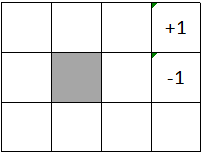

Fig 1. Gridworld








## Bellman Equations

* Given an MDP, the equations allow us to solve for value functions for any policy. All RL algorithms aim to solve the value functions.
---
**Value Functions**
* In general, the return is dependent on the policy and also the current state.
 * In the Gridworld example (Fig. 1), states (i.e. locations) closer to the goal of $+1$ will have higher returns than states further away (assuming $\gamma < 1$).
* As the return is a random variable (and not deterministic), what we can realistically do is to maximise the _expected_ return. There are 2 approaches for this:
 * **_State value function_**: $\; V_{\pi}(s) = \Bbb{E_{\pi}}[G_{t}|S_{t} = s]$
 * **_Action (or state-action) value function_**: $\; Q_{\pi}(s,a) = \Bbb{E_{\pi}}[G_{t}|S_{t} = s, A_{t} = a]$

* In other words, the value function is the expected cumulative reward (i.e. the return) from a state $s$ at time $t$ (and taking action $a$), under the policy distribution $\pi$.
 * Note that the value of a terminal state is always $0$.

---


**State value functions**
*  Note that returns can be written in a recursive manner, $G_{t} = R(t+1) +  \gamma G_{t+1}$
*  Since the return is recursive, we rewrite the value function recursively as $$\begin{aligned} 
V_{\pi}(s) &= \Bbb{E_{\pi}}[R_{t+1} + \gamma G_{t+1}|S_{t} = s] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}+\gamma V_{\pi}(s')|S_{t} = s]
\end{aligned}$$
 * see proof below to show why expectations are equivalent.
* This means that calculating the value of the current state depends only on the next possible state; there is no need to traverse a (possibly infinite) number of future trajectories.
*  The expecation thus needs to sum over the distributions $a$, $s'$ & $r$
$$V_{\pi}(s) = \sum_{a} \pi(a|s) \sum_{s'} \sum_{r} p(s',r|s,a)\bigl(r+\gamma V_{\pi}(s')\bigr)$$
*  Solving the Bellman equations is simply solving a system of linear equations. Unfortunately, it does not scale up to larger number of states.

---

**State-Action value functions**
*  Instead of finding the value function of just the state, we can also attempt to find the value function of a state-action pair (a.k.a. the **_State-Action value function_**) $$Q_{\pi}(s,a) =\Bbb{E_{\pi}}[G_{t}|S_{t} = s,A_{t} = a]$$
 *  Note that $V_{\pi}(s) = \sum_{a} \pi(a|s) Q_{\pi}(s,a)$
* Similarly, we can write $Q_{\pi}$ recursively
$$\begin{aligned} 
Q_{\pi}(s,a) &= \Bbb{E_{\pi}}[R_{t+1} + \gamma G_{t+1}|S_{t} = s, A_{t}=a] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}+\gamma \sum_{a'} \pi(a'|s') Q_{\pi}(s',a') \ |\ S_{t} = s, A_{t}=a]
\end{aligned}$$
* Also, similarly, this means that calculating the value of the current state-action pair only depends upon all possible actions available in the next state (and not upon all possible actions).

---

**Misc**
*  When to use $V_{\pi}(s)$ and $Q_{\pi}(s,a)$?
 *  $V_{\pi}(s)$ is useful for evaluating a policy, i.e. given a policy, what is the return I can expect?
 * $Q_{\pi}(s,a)$ is useful for control, or comparison of actions to take, i.e. in state $s$, what is the best action $a$ to take?
* Nuances
 * As an intelligent agent, the policy tells me _what action to do_; _not where to go_.
 * $p(s',r|s,a)$ tells me _where I end up_, though this, in practical situations, is generally unknown.

---

**Bellman Equation in matrix form**


For any given policy $\pi$, we can express the value matrix $v$ as
$$ \mathbf{v} = \mathbf{r} + \gamma \mathbf{P} \mathbf{v} $$

\
Where 
$$\begin{aligned}
{v}_{i} &= V(S_{i}) \\
{r}_{i} &= \Bbb{E}[R_{t+1}|S_{t}=s,A_{t} \sim \pi(S_{t})] \\
{P}_{ij} &= p(s_{j}|s_{i}) = \sum_{a} \pi(a|s_{i})p(s_{j}|s_{i},a)
\end{aligned}$$

\
So it can be solved directly by
$$\begin{aligned}
\mathbf{v} &= \mathbf{r} + \gamma \mathbf{P} \mathbf{v} \\
(\mathbf{I} - \gamma \mathbf{P})\mathbf{v} &= \mathbf{r} \\
\mathbf{v} &= (\mathbf{I} - \gamma \mathbf{P})^{-1}\mathbf{r}
\end{aligned}$$

With a computational complexity of $O(\vert \mathcal{S} \vert ^{3})$

---


### PROOFS



**proof of Bellman equation for State value function**
$$\begin{aligned} 
V_{\pi}(s) &= \Bbb{E_{\pi}}[R_{t+1} + \gamma G_{t+1}|S_{t} = s] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}|S_{t} = s] + \gamma \Bbb{E_{\pi}}[G_{t+1}|S_{t} = s] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}|S_{t} = s] + \gamma \Bbb{E_{\pi}}\bigl[\Bbb{E_{\pi}}[G_{t+1}|S_{t+1} = s']|S_{t} = s \bigr] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}|S_{t} = s] + \gamma \Bbb{E_{\pi}}[V_{\pi}(s')|S_{t} = s] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}+\gamma V_{\pi}(s')|S_{t} = s]
\end{aligned}$$

Note that due to the law of total expectation, $\Bbb{E}\bigl[\Bbb{E}[X|Y]\bigr] = \Bbb{E}[X]$, both expectations below are equivalent:
$$\Bbb{E_{\pi}}[G_{t+1}|S_{t} = s] = \Bbb{E_{\pi}}\bigl[\Bbb{E_{\pi}}[G_{t+1}|S_{t+1} = s']|S_{t} = s \bigr]$$

---
**proof of Bellman equation for State-Action value function**
$$\begin{aligned} 
Q_{\pi}(s,a) &= \Bbb{E_{\pi}}[R_{t+1} + \gamma G_{t+1}|S_{t} = s, A_{t}=a] 
\\ &= \Bbb{E_{\pi}} \bigl[R_{t+1} + \gamma \Bbb{E_{\pi}}[G_{t+1}|S_{t+1}=s']|S_{t} = s, A_{t}=a \bigr] 
\\ &= \Bbb{E_{\pi}} \bigl[R_{t+1} + \gamma \sum_{a'} \pi(a'|s') \Bbb{E_{\pi}}[G_{t+1}|S_{t+1}=s',A_{t+1}=a']|S_{t} = s, A_{t}=a \bigr] 
\\ &= \Bbb{E_{\pi}}[R_{t+1}+\gamma \sum_{a'} \pi(a'|s') Q_{\pi}(s',a')|S_{t} = s, A_{t}=a]
\end{aligned}$$

---
**Proof of Law of Total Expectation**

<center>$$\begin{aligned} 
\Bbb{E}\bigl[\Bbb{E}[X|Y]\bigr] &= \Bbb{E} \Biggl[\sum_{x} x p(x|Y) \Biggr]
\\ &= \sum_{y} \Biggl[\sum_{x} x p(x|y) \Biggr] p(y)
\\ &= \sum_{y} \sum_{x} x p(x|y) p(y)
\\ &= \sum_{y} \sum_{x} x p(x,y)
\\ &= \sum_{x} x \sum_{y} p(x,y)
\\ &= \sum_{x}p(x)
\\ &= \Bbb{E}[X]
\end{aligned}$$</center>


## Example of solving an MDP

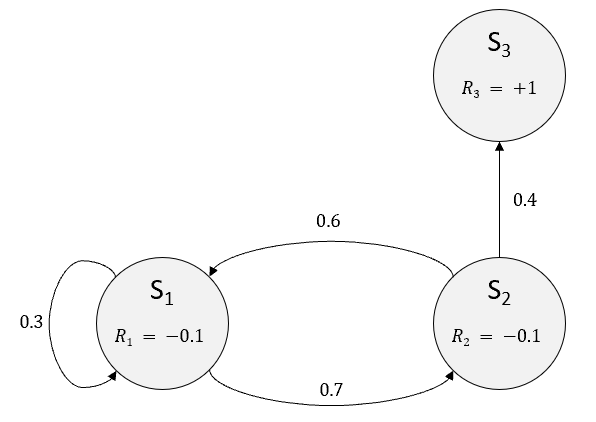

Fig 2. Example of MDP.

Using the example from Fig 2, we first note down the transition probabilities


$$
\begin{array}{c|ccc}
From/To & S_{1} & S_{2} & S_{3} \\
\hline
S_{1} & 0.3 & 0.7 & 0 \\
S_{2} & 0.6 & 0 & 0.4 \\
S_{3} & 0 & 0 & 0^{*}
\end{array}
$$

*technically $p(S_{3}|S_{3})$ is 1, since it is a terminal state, and will always recur onto itself.

\
We can then write down the values of each state in terms of the other states

$$\begin{aligned}
V(S_{1}) &= p(s1|s1)(R_{1} + \gamma V(S_{1})) + p(s2|s1)(R_{2} + \gamma V(S_{2})) + p(s3|s1)(R_{3} + \gamma V(S_{3}))
\\ V(S_{2}) &= p(s1|s2)(R_{1} + \gamma V(S_{1})) + p(s2|s2)(R_{2} + \gamma V(S_{2})) + p(s3|s2)(R_{3} + \gamma V(S_{3}))
\\ V(S_{3}) &= p(s1|s3)(R_{1} + \gamma V(S_{1})) + p(s2|s3)(R_{2} + \gamma V(S_{2})) + p(s3|s3)(R_{3} + \gamma V(S_{3}))
\end{aligned}$$

\
We however know that $V(S_{3})=0$, and by substituting in known values of $p(s'|s)$, $R_{t}$ and $\gamma = 0.9$ to the RHS, it simplifies to

$$\begin{aligned}
V(S_{1}) &= 0.3(-0.1 + \gamma V(S_{1})) + 0.7(-0.1 + \gamma V(S_{2})) + 0(1 + \gamma V(S_{3}))
\\ V(S_{2}) &= 0.6(-0.1 + \gamma V(S_{1})) + 0(-0.1 + \gamma V(S_{2})) + 0.4(1 + \gamma V(S_{3}))
\\ V(S_{3}) &= 0
\end{aligned}$$

\
Bringing all unknowns to the RHS
$$\begin{aligned}
0.1 &= -0.73 \cdot V(S_{1}) + 0.63 \cdot V(S_{2}) + 0 \cdot V(S_{3})
\\ -0.34 &= 0.54 \cdot V(S_{1}) + (-1) \cdot V(S_{2}) + 0.36 \cdot V(S_{2})
\\ 0 &= 0 \cdot V(S_{1}) + 0 \cdot V(S_{2}) + 1 \cdot V(S_{3})
\end{aligned}$$

\
In matrix form, this would be
$$\begin{equation*}
\begin{bmatrix}
-0.73 & 0.63 & 0 \\
0.54 & -1 & 0.36 \\
0 & 0 & 1
\end{bmatrix} 
\begin{bmatrix}
V(S_{1}) \\
V(S_{2}) \\
V(S_{3})
\end{bmatrix} 
=
\begin{bmatrix}
0.1 \\
-0.34 \\
0
\end{bmatrix} 
\end{equation*}$$

\
Solving for the unknowns (using `np.linalg.solver(A,b)`) gives
$$\begin{equation*}
\begin{bmatrix}
V(S_{1}) \\
V(S_{2}) \\
V(S_{3})
\end{bmatrix} 
=
\begin{bmatrix}
0.293 \\
0.498 \\
0
\end{bmatrix} 
\end{equation*}$$

---

---


In [ ]:
#solving MDP of Fig 2.

A = np.array([[-0.73,0.63,0],
              [0.54,-1,0.36],
              [0,0,1]])

b = np.array([[0.1],
              [-0.34],
              [0]])

x = np.linalg.solve(A,b)
print(x)

[[0.29297075]
 [0.49820421]
 [0.        ]]


## Optimal Policy

*  A policy can only be considered optimal if it is greater than, or equal to, another policy if and only if its value function is greater than or equal to other value functions, for every state in the state space
$$ \pi^{*} \geq \pi^{n} \iff V_{\pi^{*}}(s) \geq V_{\pi^{n}}(s), \forall s \in \mathcal{S}$$
*  This means that
$$\begin{aligned}
V^{*}(s) &= \max_{\pi} V_{\pi}(s), \forall s \in \mathcal{S} \\
\pi^{*} &= \arg \max_{\pi} V_{\pi}(s), \forall s \in \mathcal{S} \\
Q^{*}(s,a) &= \max_{\pi} Q_{\pi}(s,a), \forall s \in \mathcal{S}, \forall a \in \mathcal{A}
\end{aligned}$$
*  While we can simply find $\pi^{*}$ by looping through all possible policies, this is computationally intractable as the number of possible policies are $\vert \mathcal{A} \vert ^{\vert \mathcal{S} \vert}$
 * For our Gridworld example, Fig 1., it means that the number of policies are $4^{11} \approx 4.2 \times 10^{6}$
* Rule: Optimal value function is unique, optimal policy is not

---



**Bellman Optimality Equation**
*  To find the optimal value of a state, instead of averaging all possible action, we take the best action - the one that yields maximum value:
$$ V^{*}(s) = \max_{a} \sum_{s'} \sum_{r} p(s',r|s,a)[r + \gamma V^{*}(s')] $$
*  Similarly, for the optimal state-action:
$$ Q^{*}(s,a) = \sum_{s'} \sum_{r} p(s',r|s,a)[r + \gamma \max_{a'} Q^{*}(s',a')] $$
*  So we can relate both values as follows:
$$ V^{*}(s) = \max_{a} Q^{*}(s,a) $$
*  Since we can find the action that leads to the best value, the optimal policy is then:

$$\begin{aligned} 
\pi^{*}(s) &= \arg \max_{a} \sum_{s'} \sum_{r} p(s',r|s,a)[r + \gamma V^{*}(s')] \\
&= \arg \max_{a} Q^{*}(s,a)
\end{aligned}$$
*  Deciding whether to use $V^{*}(s)$ or $Q^{*}(s,a)$ to find $\pi^{*}$ is a recurring theme of the prediction vs control problem.
 * Prediction/Evaluation problem: How do we find $V(s)$ for a given policy?
 * Control problem: How to find the optimal policy by finding $Q^{*}$?

 ---
 
 ---



# **Dynamic Programming**

* Dynamic programming refers to a collection of algorithms that can be used
to compute optimal policies given a perfect model of the environment as a
MDP.
* For every RL algorithm, ask 2 questions:
 1. How good is the given policy? (the **_Prediction Problem_**)
 2. What is the best policy? (the **_Control Problem_**)
* Use **_policy evaluation_** for the prediction problem 
  * apply Bellman equation to obtain state values.
* Use **_policy improvement_** for the control problem 
 * obtain best policy by choosing maximal state-action values
* Repeatedly iterating between policy evaluation and policy improvement is known as **_policy iteration_**. 
* The end result of policy iteration converges into the optimal policy. However, a faster alternative to policy iteration is **_value iteration_**.  
 * Instead of waiting for policy iteration to converge, we obtain the optimal value function (based on an arbitrary initial policy) by repeatedly updating values until they converge.
 * Subsequently, obtain the optimal policy (based on the optimal value function) in a single step. 
* Though the two approaches differ in levels of granularity (w.r.t evaluation/improvement), we term such approaches under the umbrella of **_generalised policy iteration_**, i.e. the repeated iterations of updating values (evaluation), and then updating the policy (improvement), regardless of granularity. 

---

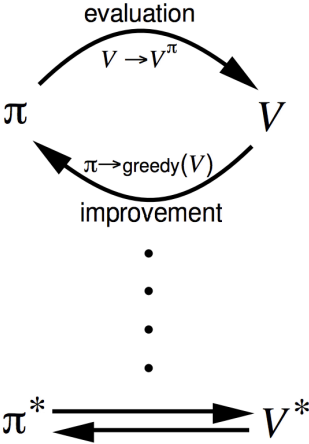

Fig 3. Depiction of Policy Iteration.

## Policy Evaluation
* What is the _value_ of a given policy?
 * Input: $\pi(a|s)$
 * Output: $V_{\pi}(s)$ or $Q_{\pi}(s,a)$
* The higher the values the better the policy.

---
* As a reminder, the Bellman equation for Policy Evaluation is:
$$V_{\pi}(s) = \sum_{a} \pi(a|s) \sum_{s'} \sum_{r} p(s',r|s,a)\bigl(r+\gamma V_{\pi}(s')\bigr)$$

### environment

In [ ]:
class GridWorld:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)]):
    '''pass in wall as a list'''
    self.rows = rows
    self.cols = cols

    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # initialise states
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position

    # define rewards
    self.Rewards = {(0,3):1,(1,3):-1}

    # initialise state values 
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # initialise random policy
    self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in self.StateSpace}
    for terminal_states in self.Rewards: self.Policy.pop(terminal_states, None)

    #for visualisation
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = 'X'
    for r in self.Rewards.keys():
      if self.Rewards[r] > 0:
        self.World[r[0],r[1]] = '+'
      elif self.Rewards[r] < 0:
        self.World[r[0],r[1]] = '-'
   
  def current_state(self):
    return self.CurrentState

  def previous_state(self):
    return self.PreviousState

  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)

  def move(self,action,verbose=False):
    # set previous state history first
    self.PreviousState = self.CurrentState.copy()
    
    # perform move & update new state
    self.CurrentState = self.get_next_state(self.PreviousState,action) #list(self.CurrentState)
    
    #print move
    if verbose: print('Agent moved from %s to %s' % (self.PreviousState,self.CurrentState))
    
    # return reward
    if self.CurrentState in self.Rewards.keys():
      return self.Rewards[self.CurrentState] #return defined rewards
    else:
      return 0
  
  def game_over(self):
    return self.CurrentState in self.Rewards.keys()

  def is_terminal(self,state):
    return state in self.Rewards.keys()

  def visualise_world(self):
    world = self.World.copy()
    r,c = self.CurrentState
    if self.CurrentState == self.PreviousState:
      world[r,c] = '*'
    else:
      world[r,c] = 'o'
    for r in world: 
      #print('-'+'--' * len(r))
      print('|'+'%s|' * len(r) %tuple(r))

  def set_policy(self,policy_dict):
    self.Policy = policy_dict
  
  def set_state_values(self,values_dict):
    self.StateValues = values_dict

  def set_rewards(self,rewards_dict):
    self.Rewards = rewards_dict

  def set_transition_proba(self,transition_dict):
    self.TransitionProb = transition_dict

  def set_action_reward(self,actionreward_dict):
    self.ActionReward = actionreward_dict

  def visualise_values(self):
    values = np.zeros((self.rows,self.cols))
    for state in self.StateValues.keys():
      r,c = state
      values[r,c] = self.StateValues[state]
    for rows in values:
      print('|',end="")
      for c in rows:
        if c >= 0:
          print(' %.2f|' % c, end="")
        else:
          print('%.2f|' % c, end="")
      print('\n',end="")
  
  def visualise_policy(self):
    polmap = self.World.copy() #np.array([[' ' for _ in range(self.cols)] for _ in range(rows)])
    for state in self.Policy:
      r,c = state
      action = list(self.Policy[state].keys())[0]
      if action == 'U':
        polmap[r,c] = '^'
      elif action == 'D':
        polmap[r,c] = 'v'
      elif action == 'L':
        polmap[r,c] = '<'
      elif action == 'R':
        polmap[r,c] = '>'
    for p in polmap: print('|'+'%s|' * len(p) %tuple(p))

  

### solving

In [ ]:
## DEFINE TRANSITIONS & POLICY
# constants
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9

# initialise gridworld
grid = GridWorld()

# generate transition probabilities
transition_dict = {}
actionreward_dict = {}
for r in range(grid.rows):
  for c in range(grid.cols):
    state = (r,c)
    if not grid.is_terminal(state):
      for action in grid.ActionSpace:
        next_state = grid.get_next_state(state,action)
        if state != next_state:
          transition_dict[(state,action,next_state)] = 1
        #if next_state in grid.Rewards:
          #actionreward_dict[(state,action,next_state)] = grid.Rewards[next_state]

grid.set_transition_proba(transition_dict)
grid.set_action_reward(actionreward_dict)

# set a fixed policy
set_policy = {(0, 0): {'R':1},
              (0, 1): {'R':1},
              (0, 2): {'R':1},
              (1, 0): {'U':1},
              (1, 2): {'U':1},
              (2, 0): {'U':1},
              (2, 1): {'R':1},
              (2, 2): {'U':1},
              (2, 3): {'L':1}}

grid.set_policy(set_policy)
print('Set Policy')
grid.visualise_policy()
print('\n\n')

# POLICY EVALUATION
# repeat until convergence
iter = 0
while True:
  biggest_change = 0

  for state in grid.StateSpace: #state = list(a.StateValues.keys())[0]
    if not grid.is_terminal(state): #if it is not a terminal state
      old_v = grid.StateValues[state]
      new_v = 0 #accumulate this
      
      for action in grid.ActionSpace:
        for next_state in grid.StateSpace:

          #action probability is deterministic, pi(a|s)
          action_prob = grid.Policy[state].get(action,0)
          #action_prob = 1 if list(grid.Policy[state].keys())[0] == action else 0

          # get transition probabilities, p(s'|s,a)
          transition_prob = grid.TransitionProb.get((state,action,next_state),0)

          # reward is a function of (s,a,s'), 0 if not specified
          curr_reward = grid.Rewards.get(next_state,0)
          #curr_reward = grid.ActionReward.get((state,action,next_state),0)

          
          # sum
          new_v += action_prob * transition_prob * (curr_reward  + GAMMA * grid.StateValues[next_state])
          #if action_prob: print('state: %s, action: %s, next_state: %s, V[s]: %.2f' % (state,action,next_state,new_v))

      # after done getting new value, update value table
      biggest_change = max(biggest_change,np.abs(new_v - old_v))
      grid.StateValues[state] = new_v
      

  print('iteration: %d, biggest change: %.2f' % (iter,biggest_change))
  grid.visualise_values()
  iter += 1

  print('\n\n')

  if biggest_change < CONVERGENCE_LIMIT:
    break


Set Policy
|>|>|>|+|
|^|X|^|-|
|^|>|^|<|



iteration: 0, biggest change: 1.00
| 0.00| 0.00| 1.00| 0.00|
| 0.00| 0.00| 0.90| 0.00|
| 0.00| 0.00| 0.81| 0.73|



iteration: 1, biggest change: 0.90
| 0.00| 0.90| 1.00| 0.00|
| 0.00| 0.00| 0.90| 0.00|
| 0.00| 0.73| 0.81| 0.73|



iteration: 2, biggest change: 0.81
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00| 0.90| 0.00|
| 0.66| 0.73| 0.81| 0.73|



iteration: 3, biggest change: 0.00
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00| 0.90| 0.00|
| 0.66| 0.73| 0.81| 0.73|





Note to self: changes don't match with the video because of the order of the `StateSpace` that is explored every iteration, but they will eventually converge onto the same values. 

---

In [ ]:
## WINDY GRIDWORLD - CHANCE TRANSITION PROBABILITY
# constants
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
STEP_COST = -.01

# initialise gridworld
grid = GridWorld()

# generate transition probabilities
transition_dict = {}
#actionreward_dict = {}
for r in range(grid.rows):
  for c in range(grid.cols):
    state = (r,c)
    if not grid.is_terminal(state):
      for action in grid.ActionSpace:
        next_state = grid.get_next_state(state,action)
        #if state != next_state:
        transition_dict[(state,action,next_state)] = 1
        #if next_state in grid.Rewards:
          #actionreward_dict[(state,action,next_state)] = grid.Rewards[next_state]

windy_cells = {(1,2):{'action':'U',
                      'trans':{(0,2):0.5,
                               (1,3):0.5}}}
for state in windy_cells:
  action = windy_cells[state]['action']
  for next_state in windy_cells[state]['trans']:
    transition_dict[(state,action,next_state)] = windy_cells[state]['trans'][next_state]

grid.set_transition_proba(transition_dict)
#grid.set_action_reward(actionreward_dict)

# set a fixed policy
set_policy = {(0, 0): {'R':1},
              (0, 1): {'R':1},
              (0, 2): {'R':1},
              (1, 0): {'U':1},
              (1, 2): {'U':1},
              (2, 0): {'U':0.5,'R':0.5},
              (2, 1): {'R':1},
              (2, 2): {'U':1},
              (2, 3): {'L':1}}

grid.set_policy(set_policy)
print('Set Policy')
grid.visualise_policy()
print('\n\n')

# POLICY EVALUATION
# repeat until convergence
iter = 0
while True:
  biggest_change = 0

  for state in grid.StateSpace: #state = list(a.StateValues.keys())[0]
    if not grid.is_terminal(state): #if it is not a terminal state
      old_v = grid.StateValues[state]
      new_v = 0 #accumulate this
      
      for action in grid.ActionSpace:
        for next_state in grid.StateSpace:

          #action probability is deterministic, pi(a|s)
          action_prob = grid.Policy[state].get(action,0)
          #action_prob = 1 if grid.Policy[state] == action else 0

          # get transition probabilities, p(s'|s,a)
          transition_prob = grid.TransitionProb.get((state,action,next_state),0)

          # reward is a function of (s,a,s'), 0 if not specified
          curr_reward = grid.Rewards.get(next_state,0)
          #curr_reward = grid.ActionReward.get((state,action,next_state),0)

          
          # sum
          new_v += action_prob * transition_prob * (curr_reward  + GAMMA * grid.StateValues[next_state])
          #if action_prob: print('state: %s, action: %s, next_state: %s, V[s]: %.2f' % (state,action,next_state,new_v))

      # after done getting new value, update value table
      biggest_change = max(biggest_change,np.abs(new_v - old_v))
      grid.StateValues[state] = new_v
      

  print('iteration: %d, biggest change: %.2f' % (iter,biggest_change))
  grid.visualise_values()
  iter += 1

  print('\n\n')

  if biggest_change < CONVERGENCE_LIMIT:
    break



Set Policy
|>|>|>|+|
|^|X|^|-|
|^|>|^|<|



iteration: 0, biggest change: 1.00
| 0.00| 0.00| 1.00| 0.00|
| 0.00| 0.00|-0.05| 0.00|
| 0.00| 0.00|-0.04|-0.04|



iteration: 1, biggest change: 0.90
| 0.00| 0.90| 1.00| 0.00|
| 0.00| 0.00|-0.05| 0.00|
| 0.00|-0.04|-0.04|-0.04|



iteration: 2, biggest change: 0.81
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00|-0.05| 0.00|
| 0.31|-0.04|-0.04|-0.04|



iteration: 3, biggest change: 0.00
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00|-0.05| 0.00|
| 0.31|-0.04|-0.04|-0.04|





---

## Policy Improvement

* What is the _best policy_? In other words, given a policy, how do I find a better policy?
* Assume that $\pi$ is given, and we have found $V_{\pi}(s)$ and $Q_{\pi}(s,a)$. Suppose that we take an action _not_ prescribed by the policy, i.e. $a \not= \pi(s)$, but then follow $\pi(s)$ thereafter. This can be calculated via Q-values.
 * if $Q_{\pi}(s,a) > V_{\pi}(s)$, then our return for the episode would be better than just following $\pi$ the whole time. i.e. just one change can improve our expected return.
* To find the best action, just look over the Q-table and take the max, i.e. we improve our policy greedily
$$ a^{*} = \arg \max_{a} Q_{\pi}(s,a) $$
* If we perform this new action $a^{*}$ _every time_ we re-visit the same state, then we have a new policy, i.e. $\pi'(s) \not= \pi(s)$ 
  * note that this is different from what was previously described, where it implies going back to the same policy $\pi(s)$ after deviating _just once_.
* **_Policy Improvement Theorem_**: New policy will be better as long as the new Q-value is larger than the previous state value, i.e.
$$\pi'(s) > \pi(s) \iff Q_{\pi}(s,\pi'(s)) \geq V_{\pi}(s)$$
that is to say,
$$ \text{If} \ Q_{\pi}(s,\pi'(s)) \geq V_{\pi}(s)$$
$$ \text{Then} \ V_{\pi'}(s) \geq V_{\pi}(s), \forall s \in \mathcal{S} $$
 * If doing $a'$ _once_ is better than doing $a$ when visiting state $s$, then it is better to do so _every time_ we visit state $s$.
* For all states except the terminal state,
$$\begin{aligned} 
\pi'(s) &= \arg \max_{a} Q_{\pi}(s,a)
\\ &=  \arg \max_{a} \sum_{s'} \sum_{r} p(s',r|s,a)[r + \gamma V_{\pi}(s')], \forall s \in \mathcal{S}, s \not= S^T
\end{aligned}$$
* Banach fixed point theorem implies that this procedure converges towards optimal policy, because policy will never get worse.
* Note that while optimal values are unique, optimal policies are not necessarily so. Thus, to prevent an infinite loop of policy evaluation - policy improvement, we can stop once the values are stable (and will also be certain of obtaining at least 1 optimal policy).

### environment

In [ ]:
class GridWorld2:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)],rewards_dict={(0,3):1,(1,3):-1},step_cost=0):
    '''pass in wall as a list'''
    self.rows = rows
    self.cols = cols

    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # initialise states
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position

    # define rewards
    self.Rewards = rewards_dict
    self.TerminalStates = list(self.Rewards.keys())

    # define step cost
    self.StepCost = step_cost

    # initialise state values 
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # define transition probabilities
    self.TransitionProb = {}
    for r in range(self.rows):
      for c in range(self.cols):
        state = (r,c)
        if state not in self.TerminalStates:
          for action in self.ActionSpace:
            #move
            next_state = list(state)
            if action == 'U':
              next_state[0] -= 1
            elif action == 'D':
              next_state[0] += 1
            elif action == 'L':
              next_state[1] -= 1
            elif action == 'R':
              next_state[1] += 1
            next_state = tuple(next_state)

            #check if valid
            if next_state in self.StateSpace:
              next_state_actual = next_state
            else:
              next_state_actual = state
            
            #assign transition probability
            self.TransitionProb[(state,action,next_state_actual)] = 1

    # initialise random policy
    self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in self.StateSpace}
    for terminal_states in self.TerminalStates: self.Policy.pop(terminal_states, None)

    #for visualisation
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = '#'
    for r in self.Rewards.keys():
      if self.Rewards[r] > 0:
        self.World[r[0],r[1]] = '+'
      elif self.Rewards[r] < 0:
        self.World[r[0],r[1]] = '-'
    
  #set
  def set_policy(self,policy_dict):
    self.Policy = policy_dict
  
  def set_state_values(self,values_dict):
    self.StateValues = values_dict

  def set_transition_proba(self,transition_dict):
    self.TransitionProb = transition_dict

  
  #gets
  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)

  def get_reward(self,next_state):
    return self.Rewards.get(next_state,self.StepCost)
  
  #utils
  def move(self,action,verbose=False):
    # set previous state history first
    self.PreviousState = self.CurrentState.copy()
    
    # perform move & update new state
    self.CurrentState = self.get_next_state(self.PreviousState,action) #list(self.CurrentState)
    
    #print move
    if verbose: print('Agent moved from %s to %s' % (self.PreviousState,self.CurrentState))
    
    # return reward
    if self.CurrentState in self.Rewards.keys():
      return self.Rewards[self.CurrentState] #return defined rewards
    else:
      return 0
  
  def game_over(self):
    return self.CurrentState in self.Rewards.keys()

  def is_terminal(self,state):
    return state in self.Rewards.keys()


  #visualisers
  def visualise_world(self):
    world = self.World.copy()
    r,c = self.CurrentState
    if self.CurrentState == self.PreviousState:
      world[r,c] = '*'
    else:
      world[r,c] = 'o'
    for r in world: 
      #print('-'+'--' * len(r))
      print('|'+'%s|' * len(r) %tuple(r))

  def visualise_values(self):
    values = np.zeros((self.rows,self.cols))
    for state in self.StateValues.keys():
      r,c = state
      values[r,c] = self.StateValues[state]
    for rows in values:
      print('|',end="")
      for c in rows:
        if c >= 0:
          print(' %.2f|' % c, end="")
        else:
          print('%.2f|' % c, end="")
      print('\n',end="")
  
  def visualise_policy(self):
    polmap = self.World.copy() #np.array([[' ' for _ in range(self.cols)] for _ in range(rows)])
    for state in self.Policy:
      r,c = state
      action = list(self.Policy[state].keys())[0]
      if action == 'U':
        polmap[r,c] = '^'
      elif action == 'D':
        polmap[r,c] = 'v'
      elif action == 'L':
        polmap[r,c] = '<'
      elif action == 'R':
        polmap[r,c] = '>'
    for p in polmap: print('|'+'%s|' * len(p) %tuple(p))


### solving
---

In [ ]:
## STANDARD GRIDWORLD
# constants
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9

eval_pass = 0
iter_pass = 0

# initialise gridworld
#grid = GridWorld2(5,5,(4,0),walls = [(1,1),(2,1),(3,1)],rewards_dict={(0,0):-1,(4,4):1})
grid = GridWorld2()

print('initial policy')
grid.visualise_policy()
# print('\ninitial values')
# grid.visualise_values()
print('\n\n')    

# start Eval-Iter loop
while True:
  ## POLICY EVALUATION LOOP
  while True:
    biggest_change = 0
    for state in grid.StateSpace: #state = list(a.StateValues.keys())[0]
      if not grid.is_terminal(state): #if it is not a terminal state
        old_v = grid.StateValues[state]
        new_v = 0 #accumulate this
        
        for action in grid.ActionSpace:
          for next_state in grid.StateSpace:

            #action probability is deterministic, pi(a|s)
            action_prob = grid.Policy[state].get(action,0)

            # get transition probabilities, p(s'|s,a)
            transition_prob = grid.TransitionProb.get((state,action,next_state),0)

            # reward is a function of (s,a,s'), 0 if not specified
            curr_reward = grid.get_reward(next_state)
            
            # sum
            new_v += action_prob * transition_prob * (curr_reward  + GAMMA * grid.StateValues[next_state])
            
        # after done getting new value, update value table
        biggest_change = max(biggest_change,np.abs(new_v - old_v))
        grid.StateValues[state] = new_v
  
    # evaluate current policy repeatedly until values have been propogated to all cells and converged
    if biggest_change < CONVERGENCE_LIMIT:
      eval_pass += 1
      break

  print('Evaluation loop %d done' % (eval_pass))
  del state, action, next_state

  ## POLICY ITERATION LOOP
  is_policy_converged = True
  #loop through every state that has a Policy
  for state in grid.Policy: 
    action_old = max(grid.Policy[state], key=grid.Policy[state].get) #get the current assigned action (or best action if probabilistic)
    action_new = None #init new action
    best_value = float('-inf')
    
    #now loop through every possible action (up, down, left, right)
    for action in grid.ActionSpace: 
      q = 0 #initialise Q-value of this action
      for next_state in grid.StateSpace:
        # get transition probabilities of next state, if action was performed
        transition_prob = grid.TransitionProb.get((state,action,next_state),0)
        
        #get reward of next state, if action was performed
        curr_reward = grid.get_reward(next_state)
        
        #update q of this action
        q += transition_prob * (curr_reward + GAMMA * grid.StateValues[next_state])
      
      #after q has been summed for all successor states, for this action,
      if q > best_value:
        best_value = q #update best_value if this action improved state value
        action_new = action #record this action as the best action for now
    
    #after all actions have been looped through
    grid.Policy[state] = {action_new : 1}

    #change policy converged flag to False, so long as at least 1 action in the policy was updated.
    if action_new != action_old: is_policy_converged = False
  
  #update number of times policy iteration has completed
  iter_pass += 1
  print('Iteration loop %d done' % (iter_pass))
  
  #after looping through all policies, if policies were updated, then break.
  #If not, since all policies have been scanned through and updated, re-evaluate the new policy again.
  if is_policy_converged:
    print('Finished')
    break
    

print('\n\n')
print('final policy')  
grid.visualise_policy()
print('\nfinal values')  
grid.visualise_values()    

#del grid

initial policy
|^|>|v|+|
|<|#|^|-|
|<|^|v|^|



Evaluation loop 1 done
Iteration loop 1 done
Evaluation loop 2 done
Iteration loop 2 done
Evaluation loop 3 done
Iteration loop 3 done
Evaluation loop 4 done
Iteration loop 4 done
Evaluation loop 5 done
Iteration loop 5 done
Finished



final policy
|>|>|>|+|
|^|#|^|-|
|^|>|^|<|

final values
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00| 0.90| 0.00|
| 0.66| 0.73| 0.81| 0.73|


In [ ]:
## WINDY GRIDWORLD
# constants
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
PENALTY = -.1 #also see how value changes for 0, -.2, -.4, -.5 & -2

eval_pass = 0
iter_pass = 0

# initialise gridworld
grid = GridWorld2(step_cost = PENALTY)

print('initial policy')
grid.visualise_policy()
# print('\ninitial values')
# grid.visualise_values()
print('\n\n')    

# set windy cells
transition_dict_ = grid.TransitionProb.copy()
windy_cells = {(1,2):{'action':'U',
                      'trans':{(0,2):0.5,
                               (1,3):0.5}}}
for state in windy_cells:
  action = windy_cells[state]['action']
  for next_state in windy_cells[state]['trans']:
    transition_dict_[(state,action,next_state)] = windy_cells[state]['trans'][next_state]

grid.set_transition_proba(transition_dict_)

# start Eval-Iter loop
while True:
  ## POLICY EVALUATION LOOP
  while True:
    biggest_change = 0
    for state in grid.StateSpace: #state = list(a.StateValues.keys())[0]
      if not grid.is_terminal(state): #if it is not a terminal state
        old_v = grid.StateValues[state]
        new_v = 0 #accumulate this
        
        for action in grid.ActionSpace:
          for next_state in grid.StateSpace:

            #action probability is deterministic, pi(a|s)
            action_prob = grid.Policy[state].get(action,0)

            # get transition probabilities, p(s'|s,a)
            transition_prob = grid.TransitionProb.get((state,action,next_state),0)

            # reward is a function of (s,a,s'), 0 if not specified
            curr_reward = grid.get_reward(next_state)
            
            # sum
            new_v += action_prob * transition_prob * (curr_reward  + GAMMA * grid.StateValues[next_state])
            
        # after done getting new value, update value table
        biggest_change = max(biggest_change,np.abs(new_v - old_v))
        grid.StateValues[state] = new_v
  
    # evaluate current policy repeatedly until values have been propogated to all cells and converged
    if biggest_change < CONVERGENCE_LIMIT:
      eval_pass += 1
      break

  print('Evaluation loop %d done' % (eval_pass))
  del state, action, next_state

  ## POLICY ITERATION LOOP
  is_policy_converged = True
  #loop through every state that has a Policy
  for state in grid.Policy: 
    action_old = max(grid.Policy[state], key=grid.Policy[state].get) #get the current assigned action (or best action if probabilistic)
    action_new = None #init new action
    best_value = float('-inf')
    
    #now loop through every possible action (up, down, left, right)
    for action in grid.ActionSpace: 
      q = 0 #initialise Q-value of this action
      for next_state in grid.StateSpace:
        # get transition probabilities of next state, if action was performed
        transition_prob = grid.TransitionProb.get((state,action,next_state),0)
        
        #get reward of next state, if action was performed
        curr_reward = grid.get_reward(next_state)
        
        #update q of this action
        q += transition_prob * (curr_reward + GAMMA * grid.StateValues[next_state])
      
      #after q has been summed for all successor states, for this action,
      if q > best_value:
        best_value = q #update best_value if this action improved state value
        action_new = action #record this action as the best action for now
    
    #after all actions have been looped through
    grid.Policy[state] = {action_new : 1}

    #change policy converged flag to False, so long as at least 1 action in the policy was updated.
    if action_new != action_old: is_policy_converged = False
  
  #update number of times policy iteration has completed
  iter_pass += 1
  print('Iteration loop %d done' % (iter_pass))
  
  #after looping through all policies, if policies were updated, then break.
  #If not, since all policies have been scanned through and updated, re-evaluate the new policy again.
  if is_policy_converged:
    print('Finished')
    break
    

print('\n\n')
print('final policy')  
grid.visualise_policy()
print('\nfinal values')  
grid.visualise_values()    


initial policy
|<|v|^|+|
|^|I|>|-|
|v|^|v|>|



Evaluation loop 1 done
Iteration loop 1 done
Evaluation loop 2 done
Iteration loop 2 done
Evaluation loop 3 done
Iteration loop 3 done
Evaluation loop 4 done
Iteration loop 4 done
Evaluation loop 5 done
Iteration loop 5 done
Evaluation loop 6 done
Iteration loop 6 done
Evaluation loop 7 done
Iteration loop 7 done
Evaluation loop 8 done
Iteration loop 8 done
Finished



final policy
|>|>|>|+|
|^|I|v|-|
|^|<|<|<|

final values
| 0.62| 0.80| 1.00| 0.00|
| 0.46| 0.00|-0.04| 0.00|
| 0.31| 0.18| 0.06|-0.04|


---


## Value iteration
* As can be seen from the previous section, policy iteration consists of 2 nested loops. This could take a long time to converge (if at all).
* We can speed up the process by
 * Computing optimal state values by _repeatedly updating_ state values only, without regard for the action, i.e. evaluate each policy via
 $$ v_{k+1}(s) = \max_{a} \sum_{s'} \sum_{r} p(s',r|s,a)[r + \gamma v_{k}(s)] $$
 and whenever $v_{k+1}(s) = v_{k}(s)$, we must have found $v^{*}$
 * Proceeding to policy improvement from optimal state values.
 $$\pi^{*}(s) = \arg \max_{a} Q_{\pi}(s,a)$$


In [ ]:
## VALUE ITERATION
# constants
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
PENALTY = 0

eval_pass = 0
iter_pass = 0

# initialise gridworld
#grid = GridWorld2(step_cost=PENALTY)
#grid = GridWorld2(5,5,(4,0),walls = [(1,1),(2,1),(3,1)],rewards_dict={(0,0):-1,(4,4):1})
grid = GridWorld2(5,5,(4,0),walls = [(1,1),(2,2),(3,1)],rewards_dict={(0,0):-1,(4,4):1})

print('initial policy')
grid.visualise_policy()
# print('\ninitial values')
# grid.visualise_values()
print('\n')    

# set windy cells
transition_dict_ = grid.TransitionProb.copy()
windy_cells = {(1,2):{'action':'U',
                      'trans':{(0,2):0.5,
                               (1,3):0.5}}}
for state in windy_cells:
  action = windy_cells[state]['action']
  for next_state in windy_cells[state]['trans']:
    transition_dict_[(state,action,next_state)] = windy_cells[state]['trans'][next_state]

grid.set_transition_proba(transition_dict_)

## VALUE ITERATION LOOP
while True:
  biggest_change = 0
  for state in grid.StateSpace: #state = list(a.StateValues.keys())[0]
    if not grid.is_terminal(state): #if it is not a terminal state
      old_v = grid.StateValues[state]
      new_v = float('-inf') #set lowest possible value for new_v
      
      ## find max value
      #loop through all actions
      for action in grid.ActionSpace:
        v = 0
        for next_state in grid.StateSpace:
          # get transition probabilities, p(s'|s,a)
          transition_prob = grid.TransitionProb.get((state,action,next_state),0)

          # reward is a function of (s,a,s'), 0 if not specified
          curr_reward = grid.get_reward(next_state)

          # sum across all possible V(s') in the current state
          v += transition_prob * (curr_reward  + GAMMA * grid.StateValues[next_state])
          
        # take max new_v
        if v > new_v:
          new_v = v
          
      # after done getting new value, update value table
      biggest_change = max(biggest_change,np.abs(new_v - old_v))
      grid.StateValues[state] = new_v

  # evaluate current policy repeatedly until values have been propogated to all cells and converged
  if biggest_change < CONVERGENCE_LIMIT:
    eval_pass += 1
    break

## Update Policy
#loop through every state that has a Policy
for state in grid.Policy: 
  action_new = None #init new action
  best_value = float('-inf')
  
  #now loop through every possible action (up, down, left, right)
  for action in grid.ActionSpace: 
    q = 0 #initialise Q-value of this action
    for next_state in grid.StateSpace:
      # get transition probabilities of next state, if action was performed
      transition_prob = grid.TransitionProb.get((state,action,next_state),0)
      
      #get reward of next state, if action was performed
      curr_reward = grid.get_reward(next_state)
      
      #update q of this action
      q += transition_prob * (curr_reward + GAMMA * grid.StateValues[next_state])
    
    #after q has been summed for all successor states, for this action,
    if q > best_value:
      best_value = q #update best_value if this action improved state value
      action_new = action #record this action as the best action for now
  
  #after all actions have been looped through
  grid.Policy[state] = {action_new : 1}

print('final policy')  
grid.visualise_policy()
print('\nfinal values')  
grid.visualise_values()   

initial policy
|-|<|v|<|>|
|>|I|^|^|>|
|v|<|I|>|v|
|>|I|>|v|<|
|<|v|v|v|+|


final policy
|-|>|v|v|v|
|v|I|>|v|v|
|v|<|I|v|v|
|v|I|v|v|v|
|>|>|>|>|+|

final values
| 0.00| 0.53| 0.59| 0.66| 0.73|
| 0.53| 0.00| 0.66| 0.73| 0.81|
| 0.59| 0.53| 0.00| 0.81| 0.90|
| 0.66| 0.00| 0.81| 0.90| 1.00|
| 0.73| 0.81| 0.90| 1.00| 0.00|


# **Monte-Carlo Methods**

* MC methods directly sample episodes. We can used the experience sampled to learn when the environment dynamics are unknown (i.e. no knowledge of MDP required).

## Monte Carlo Policy Evaluation

* Given a policy $\pi$, how can we find $V_{\pi}(s)$ or $Q_{\pi}(s,a)$ without knowing the environment dynamics, $p(s',r|s,a)$?
* Play a bunch of episodes, collect $G$ samples, and average:
$$V_{\pi}(s) = \Bbb{E}[G_{t}|S_{t} = s] \approx \frac{1}{N} \sum_{i=1}^{N}G_{i,s}$$
Where $G_{i,s}$ represents the $i$-th sample return from state $s$.

--- 

**Issues to consider**
* What is the value of a state _not_ visited by our policy? 
 * If we keep a **_probabilistic policy, with non-zero probability for all actions_**, then it would not be an issue.
* What if we encounter the same state more than once? Is the return the sum of rewards after the first visit, or after subsequent visits? We can either do:
 * **_First visit MC_**: only count the first visit
 * **_Every visit MC_**: count every visit
 * Both options converge to the same answer
* What if policy results in an infinite cycle?
 * terminate episode after a max number of steps.

---


### environment

In [ ]:
class GridWorld3:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)],rewards_dict={(0,3):1,(1,3):-1},step_cost=0):
    '''pass in wall as a list'''
    self.rows = rows
    self.cols = cols
    

    ## ENVIRONMENT MODEL
    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    self.Walls = walls
    for wall in self.Walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # define rewards
    self.Rewards = rewards_dict
    self.TerminalStates = list(self.Rewards.keys())

    # define step cost
    self.StepCost = step_cost

    # define transition probabilities
    self.TransitionProb = {}
    for r in range(self.rows):
      for c in range(self.cols):
        state = (r,c)
        if state not in self.TerminalStates:
          for action in self.ActionSpace:
            #move
            next_state = list(state)
            if action == 'U':
              next_state[0] -= 1
            elif action == 'D':
              next_state[0] += 1
            elif action == 'L':
              next_state[1] -= 1
            elif action == 'R':
              next_state[1] += 1
            next_state = tuple(next_state)

            #check if valid
            if next_state in self.StateSpace:
              next_state_actual = next_state
            else:
              next_state_actual = state
            
            #assign transition probability
            self.TransitionProb[(state,action,next_state_actual)] = 1

    #for visualisation
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = '#'
    for r in self.Rewards.keys():
      if self.Rewards[r] > 0:
        self.World[r[0],r[1]] = '+'
      elif self.Rewards[r] < 0:
        self.World[r[0],r[1]] = '-'

    ##--------------------------------------------------------------------##

    ## INITIALISED VALUES FOR LEARNING
    # initialise states
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position
   
    # initialise state values 
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # initialise random policy (here we assume NO KNOWLEDGE of the environment)
    self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # initialise returns
    self.Returns = {s:[] for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    ##--------------------------------------------------------------------##

  #set
  def set_policy(self,policy_dict):
    self.Policy = policy_dict
  
  def set_state_values(self,values_dict):
    self.StateValues = values_dict

  def set_transition_proba(self,transition_dict):
    self.TransitionProb = transition_dict

  def set_fixed_policy(self):
    # set a fixed policy
    self.Policy = {(0, 0): {'R':1},
                  (0, 1): {'R':1},
                  (0, 2): {'R':1},
                  (1, 0): {'U':1},
                  (1, 2): {'U':1},
                  (2, 0): {'U':1},
                  (2, 1): {'R':1},
                  (2, 2): {'U':1},
                  (2, 3): {'L':1}}
  
  def set_random_policy(self):
    self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  #gets
  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]
  
  def get_valid_states(self):
    available_states = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in self.Walls: available_states.remove(wall) #set walls
    for term in self.TerminalStates: available_states.remove(term) #set walls
    return available_states

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)

  def get_reward(self,next_state):
    return self.Rewards.get(next_state,self.StepCost)
  
  #utils
  def move(self,action,verbose=False):
    # set previous state history first
    self.PreviousState = self.CurrentState
    
    # perform move & update new state
    self.CurrentState = self.get_next_state(self.PreviousState,action) #list(self.CurrentState)
    
    #print move
    if verbose: print('Agent moved from %s to %s' % (self.PreviousState,self.CurrentState))
    
    # return reward
    return self.Rewards.get(self.CurrentState,self.StepCost) #return defined rewards

  def game_over(self):
    return self.CurrentState in self.TerminalStates

  def is_terminal(self,state):
    return state in self.TerminalStates
  
  #resets
  def reset_location(self,start_position=(2,0)):
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position

  def reset_values(self):
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  #visualisers
  def visualise_world(self):
    world = self.World.copy()
    r,c = self.CurrentState
    if self.CurrentState == self.PreviousState:
      world[r,c] = '*'
    else:
      world[r,c] = 'o'
    for r in world: 
      #print('-'+'--' * len(r))
      print('|'+'%s|' * len(r) %tuple(r))

  def visualise_values(self):
    values = np.zeros((self.rows,self.cols))
    for state in self.StateValues.keys():
      r,c = state
      values[r,c] = self.StateValues[state]
    for rows in values:
      print('|',end="")
      for c in rows:
        if c >= 0:
          print(' %.2f|' % c, end="")
        else:
          print('%.2f|' % c, end="")
      print('\n',end="")
  
  def visualise_policy(self):
    polmap = self.World.copy() #np.array([[' ' for _ in range(self.cols)] for _ in range(rows)])
    for state in self.Policy:
      r,c = state
      action = list(self.Policy[state].keys())[0]
      if action == 'U':
        polmap[r,c] = '^'
      elif action == 'D':
        polmap[r,c] = 'v'
      elif action == 'L':
        polmap[r,c] = '<'
      elif action == 'R':
        polmap[r,c] = '>'
    for p in polmap: print('|'+'%s|' * len(p) %tuple(p))


### solving

In [ ]:
## MONTE CARLO PREDICTION PROBLEM
## setup
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20

## initialise environment
grid = GridWorld3()
#grid.set_fixed_policy()
#grid.set_random_policy()

policy_dict = {
    (2, 0): {'U':1},
    (1, 0): {'U':1},
    (0, 0): {'R':1},
    (0, 1): {'R':1},
    (0, 2): {'R':1},
    (1, 2): {'R':1},
    (2, 1): {'R':1},
    (2, 2): {'R':1},
    (2, 3): {'U':1},
  }
grid.set_policy(policy_dict)


available_states = grid.get_valid_states() #shortcut to define available states


## interact until convergence
#while True:
for _ in range(100):
#for ss in available_states:

  # SETUP
  s_idx = np.random.choice(len(available_states))
  grid.reset_location(available_states[s_idx]) #randomise start locations

  ## START PLAYING EPISODE
  # initialise lists to keep track of agent history
  state_history = [grid.CurrentState]
  reward_history = [0]

  # play up to MAX_EP_STEPS steps
  for i in range(MAX_EP_STEPS):
    if grid.game_over():
      #print(episode done)
      break
  
    #get action
    action = max(grid.Policy[grid.CurrentState], key=grid.Policy[grid.CurrentState].get)

    #get reward
    reward = grid.move(action) #note that this method implicitly updates grid.CurrenState

    #update state and reward history
    state_history.append(grid.CurrentState)
    reward_history.append(reward)
    
    ## print loop terminated status if max loops reached
    #if i == MAX_EP_STEPS: print('episode terminated')


  ## CALCULATE RETURNS
  old_V = grid.StateValues.copy()
  returns = {}
  G = 0
  for t in range(len(state_history)-2,-1,-1): #reverse order
    sh = state_history[t]
    rh = reward_history[t+1]

    # sum returns
    G = rh + GAMMA * G

    if sh not in state_history[:t]: #check for first-visit 
      if sh not in returns: returns[sh] = [] #create empty list if new key
      returns[sh].append(G)
      grid.StateValues[sh] = np.mean(returns[sh])
    


  # #check to see if each grid values are updated
  # for state in grid.StateValues:
  #   if np.abs(grid.StateValues[state] - old_V[state]) < CONVERGENCE_LIMIT:
  #     break_flag = True
  #   else:
  #     break_flag = False

  # if break_flag == True:
  #   break


grid.visualise_policy()
print('\n')
grid.visualise_values()

|>|>|>|+|
|^|#|>|-|
|^|>|>|^|
| 0.81| 0.90| 1.00| 0.00|
| 0.73| 0.00|-1.00| 0.00|
| 0.66|-0.81|-0.90|-1.00|


## Monte-Carlo Policy Improvement

* Now that we can evaluate policy $\pi$, and gotten an initial estimate of $V_{\pi}(s)$, how can we improve it?
* Iteration usually involves taking the argmax of the expected value of the next state $s'$, i.e.
$$\pi^{*}(s) = \arg \max_{a} \sum_{s',r} p(s',r|s,a) [r + \gamma V_{\pi}(s')]$$
* However, generally, we do not know the transition dynamics $p(s',r|s,a)$ of the environment. But note that 
$$ \sum_{s',r} p(s',r|s,a) [r + \gamma V_{\pi}(s')] = Q_{\pi}(s,a)$$
Therefore, we modify out previous Evaluation step slightly, to keep track of estimates of $Q_{\pi}(s,a)$ instead of $V_{\pi}(s)$
  * recall again that $V_{\pi}(s) = \sum_{a} \pi(a|s) Q_{\pi}(s,a)$
* Then, we obtain policy improvement by:
$$\pi^{*}(s) = \arg \max_{a} Q_{\pi}(s,a)$$
* However, now we have to keep track of even more samples than before, since $Q$ has $|S| \times |A|$ values. To ease this load, we use a strategy akin to Value Iteration, which is:
 * Play one episode, update $Q$ with the returns sampled
 * Immediately update $\pi$ using the latest $Q$
* However, if we always start at the same state, we can never obtain value estimates for other states. Thus we implement **_exploring starts_**, which is to randomly start each interaction episode at a different state.




### environment

In [ ]:
class GridWorld4:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)],rewards_dict={(0,3):1,(1,3):-1},step_cost=0):
    '''pass in wall as a list'''
        
    ## ENVIRONMENT MODEL
    self.rows = rows
    self.cols = cols

    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    self.Walls = walls
    for wall in self.Walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # define rewards
    self.Rewards = rewards_dict
    self.TerminalStates = list(self.Rewards.keys())

    # define step cost
    self.StepCost = step_cost

    # define transition probabilities
    self.TransitionProb = {}
    for r in range(self.rows):
      for c in range(self.cols):
        state = (r,c)
        if state not in self.TerminalStates:
          for action in self.ActionSpace:
            #move
            next_state = list(state)
            if action == 'U':
              next_state[0] -= 1
            elif action == 'D':
              next_state[0] += 1
            elif action == 'L':
              next_state[1] -= 1
            elif action == 'R':
              next_state[1] += 1
            next_state = tuple(next_state)

            #check if valid
            if next_state in self.StateSpace:
              next_state_actual = next_state
            else:
              next_state_actual = state
            
            #assign transition probability
            self.TransitionProb[(state,action,next_state_actual)] = 1

    # visualise world
    ## draw out cells, walls and reward locations.
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = '#'
    for re in self.Rewards.keys():
      if self.Rewards[re] > 0:
        self.World[re[0],re[1]] = '+'
      elif self.Rewards[re] < 0:
        self.World[re[0],re[1]] = '-'

    ##--------------------------------------------------------------------##

    ## INITIALISED VALUES FOR LEARNING
    # initialise states
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position
   
    # initialise state values 
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # initialise state action values
    self.StateActionValues = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    #self.StateActionValues = {(s,a):0 for a in self.ActionSpace for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    #self.StateActionVisitCounts = {(s,a):0 for a in self.ActionSpace for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    
    # initialise random policy (here we assume NO KNOWLEDGE of the environment)
    self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # # initialise returns
    # self.Returns = {s:[] for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]} #is this necessary?

    ##--------------------------------------------------------------------##

  ## SETTINGS ##
  def set_policy(self,policy_dict):
    self.Policy = policy_dict
  
  def set_state_values(self,values_dict,reset=True):
    self.StateValues = values_dict
    if reset: self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_state_action_values(self,actionvalues_dict,reset=True):
    self.StateActionValues = actionvalues_dict
    if reset: self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_transition_proba(self,transition_dict):
    self.TransitionProb = transition_dict
    
  def set_fixed_policy(self):
    # set a fixed policy
    self.Policy = {(0, 0): {'R':1},
                  (0, 1): {'R':1},
                  (0, 2): {'R':1},
                  (1, 0): {'U':1},
                  (1, 2): {'U':1},
                  (2, 0): {'U':1},
                  (2, 1): {'R':1},
                  (2, 2): {'U':1},
                  (2, 3): {'L':1}}
  
  def set_random_policy(self):
    #self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    for state in self.Policy:
      a_ = np.random.choice(self.ActionSpace)
      self.Policy[state][a_] = 1


  def set_equil_policy(self):
    self.Policy = {s:{a:1/len(self.ActionSpace) for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_V_from_Q(self):
    for state,Qs in self.StateActionValues.items():
      self.StateValues[state] = max(Qs.values())
  
  def set_state_visit_counts(self):
    for state,SV in self.StateActionVisitCounts.items():
      self.StateVisitCounts[state] = np.sum(list(SV.values()))
  
  ##--------------------------------------------------------------------##


  ## GETTINGS ##
  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]
  
  def get_valid_states(self):
    available_states = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in self.Walls: available_states.remove(wall) #set walls
    for term in self.TerminalStates: available_states.remove(term) #set walls
    return available_states

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)

  def get_reward(self,next_state):
    return self.Rewards.get(next_state,self.StepCost)
  
  ##--------------------------------------------------------------------##

  ## UTILS ##
  def move(self,action,verbose=False):
    # set previous state history first
    self.PreviousState = self.CurrentState
    
    # perform move & update new state
    self.CurrentState = self.get_next_state(self.PreviousState,action) #list(self.CurrentState)
    
    #print move
    if verbose: print('Agent moved from %s to %s' % (self.PreviousState,self.CurrentState))
    
    # return reward
    return self.Rewards.get(self.CurrentState,self.StepCost) #return defined rewards

  def game_over(self):
    return self.CurrentState in self.TerminalStates

  def is_terminal(self,state):
    return state in self.TerminalStates

  def epsilon_greedy(self,eps=.1):
    if np.random.rand() < (1 - eps): #for majority of the time, return best action (with ties broken randomly)
      max_Q = max(self.StateActionValues[self.CurrentState].values())
      max_a = []
      for act,val in self.StateActionValues[self.CurrentState].items():
        if val == max_Q:
          max_a.append(act)
      return np.random.choice(max_a)
    else: #otherwise random action
      return np.random.choice(self.ActionSpace)

  
  ##--------------------------------------------------------------------##

  ## RESETS ##
  def reset_location(self,start_position=(2,0)):
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position

  def reset_values(self):
    # state
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    # state action
    self.StateActionValues = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
  
  ##--------------------------------------------------------------------##
  
  ## VISUALISERS ##
  def visualise_world(self,view_agent_loc=True):
    world = self.World.copy()

    ## mark agent location
    if view_agent_loc:
      r,c = self.CurrentState
      if self.CurrentState == self.PreviousState:
        world[r,c] = '*'
      else:
        world[r,c] = 'o'
    
    ## display
    for r in world: 
      print('|'+'%s|' * len(r) %tuple(r))

  def visualise_values(self):
    values = np.zeros((self.rows,self.cols))

    for state,vals in self.StateValues.items():
      r,c = state
      values[r,c] = vals
    
    for rows in values:
      print('|',end="")
      for c in rows:
        if c >= 0:
          print(' %.2f|' % c, end="")
        else:
          print('%.2f|' % c, end="")
      print('\n',end="")
  
  def visualise_policy(self):
    polmap = self.World.copy() #np.array([[' ' for _ in range(self.cols)] for _ in range(rows)])
    
    #get only valid policies
    valid_policies = self.Policy.copy()
    for wall in self.Walls: valid_policies.pop(wall,None) #set walls
    for term in self.TerminalStates: valid_policies.pop(term,None) #set walls
    
    #fill in cells with arrows depicting policies
    for state,act in valid_policies.items():
      r,c = state
      a = []
      for ak,vk in act.items():
        if vk == max(act.values()):
          a.append(ak)
      action = np.random.choice(a)
      if action == 'U':
        polmap[r,c] = '^'
      elif action == 'D':
        polmap[r,c] = 'v'
      elif action == 'L':
        polmap[r,c] = '<'
      elif action == 'R':
        polmap[r,c] = '>'
    for p in polmap: print('|'+'%s|' * len(p) %tuple(p))

  def visualise_state_visit_counts(self):
    values = np.zeros((self.rows,self.cols))
    max_vs = max(self.StateVisitCounts.values()) #for formatting
    for state,vals in self.StateVisitCounts.items():
      r,c = state
      values[r,c] = vals
    for rows in values:
      print('|',end="")
      for c in rows:
        eval("print('%"+str(len(str(max_vs)))+"d|' % c, end='')")
      print('\n',end="")


### solving

init policy
|^|v|^|+|
|v|#|^|-|
|v|<|^|v|

final policy
|>|>|>|+|
|^|#|^|-|
|>|>|^|<|

final values
| 0.80| 0.90| 1.00| 0.00|
| 0.73| 0.00| 0.90| 0.00|
| 0.64| 0.72| 0.80| 0.63|





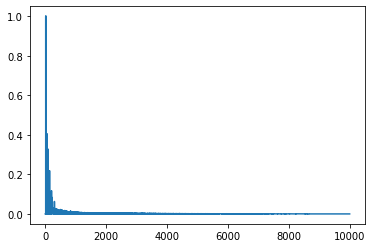

In [ ]:
## MONTE CARLO CONTROL PROBLEM - WITH EXPLORING STARTS
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20

## initialise environment
grid = GridWorld4()
grid.set_random_policy()
print('init policy')
grid.visualise_policy()
available_states = grid.get_valid_states() #shortcut to define available states

## keep track of changes to Q-values
deltas = []

## interact until convergence
# SETUP
for _ in range(10000):
  biggest_change = 0
  ## START PLAYING EPISODE
  # exploring start
  state = available_states[np.random.choice(len(available_states))] #randomise start location
  action = np.random.choice(grid.ActionSpace) #pick random action
  grid.reset_location(state) #set start locations
  
  # initialise lists to keep track of agent history
  state_history = [state]
  action_history = [action]
  reward_history = [None]

  # play up to MAX_EP_STEPS steps
  for i in range(MAX_EP_STEPS):
    #get reward
    reward = grid.move(action) #note that this method implicitly updates grid.CurrentState
    reward_history.append(reward)

    #record new state
    state_history.append(grid.CurrentState)

    #check if game over
    if grid.game_over(): 
      #if agent at terminal episode
      action_history.append(None)
      break
    else:
      #select new action, append to history
      action = max(grid.Policy[grid.CurrentState], key=grid.Policy[grid.CurrentState].get)
      action_history.append(action)



  ## CALCULATE RETURNS    
  state_action_history = list(zip(state_history,action_history))
  G=0
  for t in range(len(state_history)-2,-1,-1): #reverse order
    sh = state_history[t]
    ah = action_history[t]
    rh = reward_history[t+1]

    # increase state-action visit by 1
    grid.StateActionVisitCounts[sh][ah] += 1

    # sum returns
    G = rh + GAMMA * G

    if (sh,ah) not in state_action_history[:t]: #check for first-visit
      old_Q = grid.StateActionValues[sh][ah]
      #returns[sh][ah].append(G)
      grid.StateActionValues[sh][ah] += (1/grid.StateActionVisitCounts[sh][ah])*(G - grid.StateActionValues[sh][ah]) #Q-value
      #grid.StateActionValues[sh][ah] = np.mean(returns[sh][ah])
      
      #update policy
      max_Q = max(grid.StateActionValues[sh].values())
      max_acts = [a for a,v in grid.StateActionValues[sh].items() if v == max_Q] #use to break ties
      grid.Policy[sh] = {np.random.choice(max_acts):1} #randomly break ties if multiple actions have same Q values

      #store biggest change
      biggest_change = max(biggest_change,np.abs(old_Q - grid.StateActionValues[sh][ah]))
  
  deltas.append(biggest_change)

  ## breakpoint

  
  # if np.mean(deltas) < CONVERGENCE_LIMIT:
  #   break

#find V
grid.set_V_from_Q()



print('\nfinal policy')
grid.visualise_policy()
print('\nfinal values')
grid.visualise_values()
print('\n\n')

plt.plot(deltas)
plt.show()


**Monte-Carlo Policy Iteration Without Exploring Starts**
* However, exploring starts are usually impractical. This is because, in the real world, we do not have a complete picture of all possible states.
* To account for this problem, we utilise $\epsilon$-greedy MC control.
* Initialise a policy where $\pi(a|s) > 0, \forall a,s$.
* To update the policy, we do the following steps:
$$a^{*} = \arg \max_{a} Q(s_{t},a)$$
$$\pi(a^{*}|s_{t}) = 1 - \epsilon + \frac{\epsilon}{|A|}$$
$$\pi(a|s_{t}) = \frac{\epsilon}{|A|}, \forall a \not= a^{*}$$

init policy
|<|v|v|+|
|^|#|v|-|
|<|^|<|v|

final policy
|>|>|>|+|
|^|#|^|-|
|^|>|^|<|

final values
| 0.73| 0.85| 1.00| 0.00|
| 0.63| 0.00| 0.84| 0.00|
| 0.44| 0.50| 0.59| 0.49|





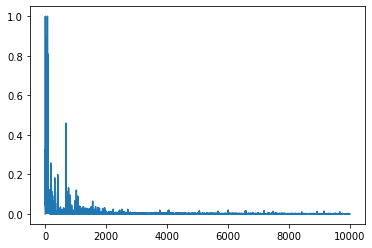

In [ ]:
## MONTE CARLO CONTROL PROBLEM - WITHOUT EXPLORING STARTS
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20
EPS = 0.3

## initialise environment
grid = GridWorld4(step_cost=0)
grid.set_equil_policy()
print('init policy')
grid.visualise_policy()
available_states = grid.get_valid_states() #shortcut to define available states

## keep track of changes to Q-values
deltas = []

## interact until convergence
# SETUP
for _ in range(10000):
  biggest_change = 0
  ## START PLAYING EPISODE
  grid.reset_location() #reset start location after every episode

  # initialise lists to keep track of agent history
  state_history = [grid.CurrentState]
  action_history = [grid.epsilon_greedy(EPS)]
  reward_history = [None]

  # play up to MAX_EP_STEPS steps
  for i in range(MAX_EP_STEPS):
    #get reward
    reward = grid.move(action) #note that this method implicitly updates grid.CurrentState
    reward_history.append(reward)

    #record new state
    state_history.append(grid.CurrentState)

    #check if game over
    if grid.game_over(): 
      #if agent at terminal episode
      action_history.append(None)
      break
    else:
      #select new action, append to history
      action = grid.epsilon_greedy(EPS)
      action_history.append(action)


  ## CALCULATE RETURNS    
  state_action_history = list(zip(state_history,action_history))
  G=0
  for t in range(len(state_history)-2,-1,-1): #reverse order
    sh = state_history[t]
    ah = action_history[t]
    rh = reward_history[t+1]

    # increase state-action visit by 1
    grid.StateActionVisitCounts[sh][ah] += 1

    # sum returns
    G = rh + GAMMA * G

    if (sh,ah) not in state_action_history[:t]: #check for first-visit
      old_Q = grid.StateActionValues[sh][ah]
      #returns[sh][ah].append(G)
      grid.StateActionValues[sh][ah] += (1/grid.StateActionVisitCounts[sh][ah])*(G - grid.StateActionValues[sh][ah]) #Q-value
      #grid.StateActionValues[sh][ah] = np.mean(returns[sh][ah])
      
      #update policy
      max_Q = max(grid.StateActionValues[sh].values())
      max_acts = [a for a,v in grid.StateActionValues[sh].items() if v == max_Q] #use to break ties
      
      grid.Policy[sh] = {a:EPS/len(grid.ActionSpace) for a in grid.ActionSpace} #update all with equal 1-eps probability
      grid.Policy[sh][np.random.choice(max_acts)] = 1 - EPS + (EPS/len(grid.ActionSpace)) #reassign max prob to best action (ties broken randomly)

      #store biggest change
      biggest_change = max(biggest_change,np.abs(old_Q - grid.StateActionValues[sh][ah]))
  
  deltas.append(biggest_change)

  ## breakpoint

  
  # if np.mean(deltas) < CONVERGENCE_LIMIT:
  #   break

#find V
grid.set_V_from_Q()

#update state-visit counts
grid.set_state_visit_counts()

print('\nfinal policy')
grid.visualise_policy()
print('\nfinal values')
grid.visualise_values()
print('\n\n')

plt.plot(deltas)
plt.show()

# **Temporal Difference learning**

* Unlike MC-learning, where we could only update our values after sampling the full return (i.e. only after episode has terminated), TD-learning updates the values towards an _estimated_ return.
* TD is usually defined by a hyperparameter $\lambda \in [0,1]$, that determines the proportion of steps to look ahead (up to episode termination), so as to estimate returns.
 * MC-learning is essentially hyperparameterised by $\lambda = 1$
 * One-step ahead TD-learning is hyperparameterised by $\lambda = 0$, and so is commonly referred to as TD(0)

## TD(0) Policy Evaluation

--- 

* Previously, to evaluate a policy, we averaged returns across all steps. However, sometimes episodes may have no clear termination points.
* As such, we utilise Exponentially Weighted Moving Average (EWMA) to iteratively update state/action values, that is to say:
$$V_{\pi}(s_{t}) = V_{\pi}(s_{t}) + \alpha[G_{t} - V_{\pi}(s_{t})]$$
Where we use a constant $\alpha$
* However note that this still requires a return value of $G$, which by definition can only be obtained after an episode terminates. We instead utilise the dynamic programming method of _estimating_ the return using the value of the next state, $V_{\pi}(s_{t+1})$, to update our values:
$$V_{\pi}(s_{t}) = V_{\pi}(s_{t}) + \alpha[r + \gamma V_{\pi}(s_{t+1}) - V_{\pi}(s_{t})]$$
This allows values to be updated even as soon as 1 reward is obtained (negating issues with long/infinitely-long episodes)


### environment

In [ ]:
class GridWorld5:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)],rewards_dict={(0,3):1,(1,3):-1},step_cost=0):
    '''pass in wall as a list'''
        
    ## ENVIRONMENT MODEL
    self.rows = rows
    self.cols = cols

    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    self.Walls = walls
    for wall in self.Walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # define rewards
    self.Rewards = rewards_dict
    self.TerminalStates = list(self.Rewards.keys())

    # define step cost
    self.StepCost = step_cost

    # # define transition probabilities
    # self.TransitionProb = {}
    # for r in range(self.rows):
    #   for c in range(self.cols):
    #     state = (r,c)
    #     if state not in self.TerminalStates:
    #       for action in self.ActionSpace:
    #         #move
    #         next_state = list(state)
    #         if action == 'U':
    #           next_state[0] -= 1
    #         elif action == 'D':
    #           next_state[0] += 1
    #         elif action == 'L':
    #           next_state[1] -= 1
    #         elif action == 'R':
    #           next_state[1] += 1
    #         next_state = tuple(next_state)

    #         #check if valid
    #         if next_state in self.StateSpace:
    #           next_state_actual = next_state
    #         else:
    #           next_state_actual = state
            
    #         #assign transition probability
    #         self.TransitionProb[(state,action,next_state_actual)] = 1

    # visualise world
    ## draw out cells, walls and reward locations.
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = '#'
    for re in self.Rewards.keys():
      if self.Rewards[re] > 0:
        self.World[re[0],re[1]] = '+'
      elif self.Rewards[re] < 0:
        self.World[re[0],re[1]] = '-'

    ##--------------------------------------------------------------------##

    ## INITIALISED VALUES FOR LEARNING
    # initialise states
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position
   
    # initialise state values 
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

    # initialise state action values
    self.StateActionValues = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
  
    # initialise random policy (here we assume NO KNOWLEDGE of the environment)
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    for state in self.Policy:
      a_ = np.random.choice(self.ActionSpace)
      self.Policy[state][a_] = 1

    ##--------------------------------------------------------------------##

  ## SETTINGS ##
  def set_policy(self,policy_dict):
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    for state,action in policy_dict.items():
      for act,val in action.items():
        self.Policy[state][act] = val
  
  def set_state_values(self,values_dict,reset=True):
    self.StateValues = values_dict
    if reset: self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_state_action_values(self,actionvalues_dict,reset=True):
    self.StateActionValues = actionvalues_dict
    if reset: self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_transition_proba(self,transition_dict):
    self.TransitionProb = transition_dict
    
  def set_fixed_policy(self):
    # set a fixed policy
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    
    fixed_policy = {(0, 0): {'R':1},
                    (0, 1): {'R':1},
                    (0, 2): {'R':1},
                    (1, 0): {'U':1},
                    (1, 2): {'U':1},
                    (2, 0): {'U':1},
                    (2, 1): {'R':1},
                    (2, 2): {'U':1},
                    (2, 3): {'L':1}}

    for state,action in fixed_policy.items():
      for act,val in action.items():
        self.Policy[state][act] = val
  
  def set_random_policy(self):
    #self.Policy = {s:{np.random.choice(['U','D','L','R']):1} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    for state in self.Policy:
      a_ = np.random.choice(self.ActionSpace)
      self.Policy[state][a_] = 1


  def set_equil_policy(self):
    self.Policy = {s:{a:1/len(self.ActionSpace) for a in self.ActionSpace} for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}

  def set_V_from_Q(self):
    for state,Qs in self.StateActionValues.items():
      self.StateValues[state] = max(Qs.values())
  
  def set_state_visit_counts(self):
    for state,SV in self.StateActionVisitCounts.items():
      self.StateVisitCounts[state] = np.sum(list(SV.values()))
  
  ##--------------------------------------------------------------------##


  ## GETTINGS ##
  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]
  
  def get_valid_states(self):
    available_states = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in self.Walls: available_states.remove(wall) #set walls
    for term in self.TerminalStates: available_states.remove(term) #set walls
    return available_states

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)

  def get_reward(self,next_state):
    return self.Rewards.get(next_state,self.StepCost)
  
  ##--------------------------------------------------------------------##

  ## UTILS ##
  def move(self,action,verbose=False):
    # set previous state history first
    self.PreviousState = self.CurrentState
    
    # perform move & update new state
    self.CurrentState = self.get_next_state(self.PreviousState,action) #list(self.CurrentState)
    
    #print move
    if verbose: print('Agent moved from %s to %s' % (self.PreviousState,self.CurrentState))
    
    # return reward
    return self.Rewards.get(self.CurrentState,self.StepCost) #return defined rewards

  def game_over(self):
    return self.CurrentState in self.TerminalStates

  def is_terminal(self,state):
    return state in self.TerminalStates

  def next_action(self):
    max_val = max(self.Policy[self.CurrentState].values())
    max_a = []
    for act,val in self.Policy[self.CurrentState].items():
      if val == max_val:
        max_a.append(act)
    return np.random.choice(max_a)


  def epsilon_greedy(self,based_on = 'policy',eps=.1):
    if np.random.rand() < (1 - eps): #for majority of the time, return best action (with ties broken randomly)
      max_a = []
      if based_on == 'policy': #actions follow Policy
        max_val = max(self.Policy[self.CurrentState].values())
        for act,val in self.Policy[self.CurrentState].items():
          if val == max_val:
            max_a.append(act)
            
      elif based_on == 'Q': #action based on best State-action values
        max_a = []
        max_val = max(self.StateActionValues[self.CurrentState].values())
        for act,val in self.StateActionValues[self.CurrentState].items():
          if val == max_val:
            max_a.append(act)

      return np.random.choice(max_a)

    else: #otherwise random action
      return np.random.choice(self.ActionSpace)

  def argmaxQ(self,state):
    max_a = []
    max_val = max(self.StateActionValues[state].values())
    for act,val in self.StateActionValues[state].items():
      if val == max_val:
        max_a.append(act)
    return np.random.choice(max_a)
  
  ##--------------------------------------------------------------------##

  ## RESETS ##
  def reset_location(self,start_position=(2,0)):
    self.StartingState = start_position
    self.PreviousState = start_position
    self.CurrentState = start_position

  def reset_values(self):
    # state
    self.StateValues = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateVisitCounts = {s:0 for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    # state action
    self.StateActionValues = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
    self.StateActionVisitCounts = {s:{a:0 for a in self.ActionSpace } for s in [(i,j) for i in range(self.rows) for j in range(self.cols)]}
  
  ##--------------------------------------------------------------------##
  
  ## VISUALISERS ##
  def visualise_world(self,view_agent_loc=True):
    world = self.World.copy()

    ## mark agent location
    if view_agent_loc:
      r,c = self.CurrentState
      if self.CurrentState == self.PreviousState:
        world[r,c] = '*'
      else:
        world[r,c] = 'o'
    
    ## display
    for r in world: 
      print('|'+'%s|' * len(r) %tuple(r))

  def visualise_values(self):
    values = np.zeros((self.rows,self.cols))

    for state,vals in self.StateValues.items():
      r,c = state
      values[r,c] = vals
    
    for rows in values:
      print('|',end="")
      for c in rows:
        if c >= 0:
          print(' %.2f|' % c, end="")
        else:
          print('%.2f|' % c, end="")
      print('\n',end="")
  
  def visualise_policy(self):
    polmap = self.World.copy() #np.array([[' ' for _ in range(self.cols)] for _ in range(rows)])
    
    #get only valid policies
    valid_policies = self.Policy.copy()
    for wall in self.Walls: valid_policies.pop(wall,None) #set walls
    for term in self.TerminalStates: valid_policies.pop(term,None) #set walls
    
    #fill in cells with arrows depicting policies
    for state,act in valid_policies.items():
      r,c = state
      a = []
      for ak,vk in act.items():
        if vk == max(act.values()):
          a.append(ak)
      action = np.random.choice(a)
      if action == 'U':
        polmap[r,c] = '^'
      elif action == 'D':
        polmap[r,c] = 'v'
      elif action == 'L':
        polmap[r,c] = '<'
      elif action == 'R':
        polmap[r,c] = '>'
    for p in polmap: print('|'+'%s|' * len(p) %tuple(p))

  def visualise_state_visit_counts(self):
    values = np.zeros((self.rows,self.cols))
    max_vs = max(self.StateVisitCounts.values()) #for formatting
    for state,vals in self.StateVisitCounts.items():
      r,c = state
      values[r,c] = vals
    for rows in values:
      print('|',end="")
      for c in rows:
        eval("print('%"+str(len(str(max_vs)))+"d|' % c, end='')")
      print('\n',end="")


### solver

In [ ]:
## TD-LEARNING: POLICY EVALUTION
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20
ALPHA = .1

## initialise environment
grid = GridWorld5()


policy = {(0, 0): {'R':1},
          (0, 1): {'R':1},
          (0, 2): {'R':1},
          (1, 0): {'U':1},
          (1, 2): {'R':1},
          (2, 0): {'U':1},
          (2, 1): {'R':1},
          (2, 2): {'R':1},
          (2, 3): {'U':1}}

grid.set_policy(policy)

#grid.set_random_policy()
print('init policy')
grid.visualise_policy()


## 
deltas = []
#while True:
for _ in range(10000):
  ## start playing
  grid.reset_location()
  
  delta = 0
  while not grid.game_over():
    #keep count of state visits
    grid.StateVisitCounts[grid.CurrentState] += 1

    #find next action
    action = grid.epsilon_greedy()

    #get reward
    reward = grid.move(action) #here the agent has moved to s'
    
    #update state value
    v_prev = grid.StateValues[grid.PreviousState]
    v_next = grid.StateValues[grid.CurrentState]

    grid.StateValues[grid.PreviousState] = v_prev + ALPHA*(reward + GAMMA*v_next - v_prev)
    
    #record change
    delta = max(delta,np.abs(grid.StateValues[grid.PreviousState] - v_prev))
  
  deltas.append(delta)
    



print('\nfinal values')
grid.visualise_values()
print('\nvisit counts')
grid.visualise_state_visit_counts()
print('\n\n')

_ = plt.plot(deltas)
  

   


init policy
|>|>|>|+|
|^|#|>|-|
|^|>|>|^|

final values
| 0.77| 0.88| 0.98| 0.00|
| 0.67| 0.00|-0.98| 0.00|
| 0.58|-0.75|-0.89|-0.99|

visit counts
|10850|10783|10279|    0|
|10831|    0|  253|    0|
|10799|  280|  280|  278|



Error in callback <function flush_figures at 0x7fc03ce2e320> (for post_execute):


KeyboardInterrupt: ignored

## TD(0) Policy Improvement

---
* after we have evaluated a policy, we now have a few methods to improve it.
 * SARSA
 * Q-learning

### SARSA

* SARSA is (s,a,r,s',a'). SARSA is **_on-policy_**, the Q-function we are learning is the Q-function we are using in the environment
* When it comes to prediction, we can use $V(s)$. But when it comes to control, we need to _compare actions_ to take, and so we must use the values derived from $Q(s,a)$
* The version of TD(0)-learning for the Q-values is:
$$Q_{\pi}(s,a) = Q_{\pi}(s,a) + \alpha [r + \gamma Q_{\pi}(s',a') - Q_{\pi}(s,a)]$$
* We refer to the return that has to be estimated, $r + \gamma Q_{\pi}(s',a')$, as the **_target_**
* To obtain the target, instead of following a given policy, our policy would be **_$\epsilon$-greedy w.r.t $Q$_**
$$a'=\begin{cases}
\arg \max_{a} Q_{\pi}(s,a)  & P(1-\epsilon) 
\\ a \sim \mathcal{A} & P(\epsilon)  
\end{cases}$$
That is to say, we use our most recent estimate of $Q$, to determine the best action to take most of the time, but with some chance of exploration


init policy
|v|^|v|+|
|^|#|v|-|
|^|<|^|<|

final policy
|>|>|>|+|
|^|#|^|-|
|^|>|^|<|

final values
| 0.62| 0.80| 1.00| 0.00|
| 0.45| 0.00| 0.75| 0.00|
| 0.27| 0.41| 0.59| 0.30|

visit counts
| 7483| 7486|10689|    0|
| 7510|    0| 3740|    0|
|10920| 3721| 3723|  118|





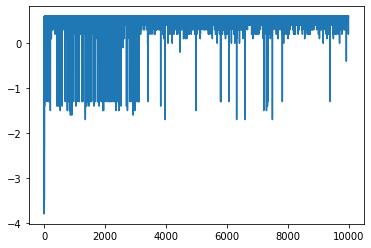

In [ ]:
## TD-LEARNING: POLICY IMPROVEMENT - SARSA
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20
ALPHA = .1

## initialise environment
grid = GridWorld5(step_cost=-.1)
#no need to set a policy

#grid.set_random_policy()
print('init policy')
grid.visualise_policy()


## 
reward_hist = []
#while True:
for _ in range(10000):
  ## start playing
  grid.reset_location()

  current_action = grid.epsilon_greedy('Q') # this is `a`
  rh = 0
  while not grid.game_over():
    #keep count of state-action visits
    grid.StateActionVisitCounts[grid.CurrentState][current_action] += 1

    #get reward
    reward = grid.move(current_action) #here the agent has moved to s'
    rh += reward

    #update state value
    next_action = grid.epsilon_greedy('Q') #this is `a'`
    q_prev = grid.StateActionValues[grid.PreviousState][current_action] #this is Q(s,a)
    q_next = grid.StateActionValues[grid.CurrentState][next_action] #this is Q(s',a')

    grid.StateActionValues[grid.PreviousState][current_action] = q_prev + ALPHA*(reward + GAMMA*q_next - q_prev)

    #update a' to a
    current_action = next_action
    
    ## record change
    #delta = max(delta,np.abs(grid.StateActionValues[grid.PreviousState][current_action] - q_prev))

  reward_hist.append(rh)

#here, we should have obtained Q*. Now, set policy according to Q*
policy_dict = {s:{a:0 for a in grid.ActionSpace} for s in [(i,j) for i in range(grid.rows) for j in range(grid.cols)]}
for state in grid.get_valid_states():
  Qs = grid.StateActionValues[state]
  max_a = []
  max_val = max(list(Qs.values()))
  for act,val in Qs.items():
    if val == max_val:
      max_a.append(act)
  policy_dict[state][np.random.choice(max_a)] = 1 
  grid.StateValues[state] = max_val
grid.Policy = policy_dict



grid.set_V_from_Q()
grid.set_state_visit_counts()
    
print('\nfinal policy')
grid.visualise_policy()
print('\nfinal values')
grid.visualise_values()
print('\nvisit counts')
grid.visualise_state_visit_counts()
print('\n\n')

_ = plt.plot(reward_hist)
  

   


### Q-learning

* While helpful for exploring, $\epsilon$-greedy is sub-optimal.
* In comparison to SARSA, Q-learning target is
$$r_{t+1} + \gamma \max_{a'}Q(s',a')$$
instead of using the _actual next action_, we use the optimal _action we would have taken_ if we had chosen the current optimal action.

* Q-learning is **_off-policy_**, actions are dictated by the $\epsilon$-greedy policy, but we are learning the Q-function for the target policy greedily.
 * **_behaviour policy_**: dictates how we act in the environment
 * **_target policy_**: the policy that we are learning; it may not be same as the one we are using to determine our actions



init policy
|^|v|>|+|
|>|#|v|-|
|<|<|<|>|

final policy
|>|>|>|+|
|^|#|^|-|
|>|>|^|<|

final values
| 0.62| 0.80| 1.00| 0.00|
| 0.46| 0.00| 0.80| 0.00|
| 0.31| 0.46| 0.62| 0.46|

visit counts
|  317|  577|10526|    0|
|  323|    0|10508|    0|
|10836|10886|10824|  321|





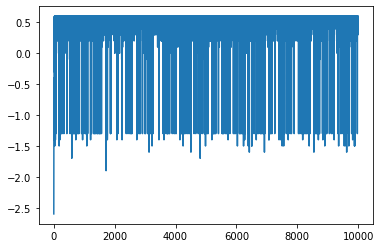

In [ ]:
## TD-LEARNING: POLICY IMPROVEMENT - Q-learning
CONVERGENCE_LIMIT = 1e-3
GAMMA = 0.9
MAX_EP_STEPS = 20
ALPHA = .1

## initialise environment
grid = GridWorld5(step_cost=-.1)
#no need to set a policy

#grid.set_random_policy()
print('init policy')
grid.visualise_policy()


## 
reward_hist = []
#while True:
for _ in range(10000):
  ## start playing
  grid.reset_location()

  
  rh = 0
  while not grid.game_over():
    #get action
    current_action = grid.epsilon_greedy('Q') # this is `a`

    #keep count of state-action visits
    grid.StateActionVisitCounts[grid.CurrentState][current_action] += 1

    #get reward
    reward = grid.move(current_action) #here the agent has moved to s'
    rh += reward

    #update state value
    q_prev = grid.StateActionValues[grid.PreviousState][current_action] #this is Q(s,a)
    q_best = max(grid.StateActionValues[grid.CurrentState].values())

    grid.StateActionValues[grid.PreviousState][current_action] = q_prev + ALPHA*(reward + GAMMA*q_best - q_prev)
    
    ## record change
    #delta = max(delta,np.abs(grid.StateActionValues[grid.PreviousState][current_action] - q_prev))

  reward_hist.append(rh)

#here, we should have obtained Q*. Now, set policy according to Q*
policy_dict = {s:{a:0 for a in grid.ActionSpace} for s in [(i,j) for i in range(grid.rows) for j in range(grid.cols)]}
for state in grid.get_valid_states():
  Qs = grid.StateActionValues[state]
  max_a = []
  max_val = max(list(Qs.values()))
  for act,val in Qs.items():
    if val == max_val:
      max_a.append(act)
  policy_dict[state][np.random.choice(max_a)] = 1 
  grid.StateValues[state] = max_val
grid.Policy = policy_dict



grid.set_V_from_Q()
grid.set_state_visit_counts()
    
print('\nfinal policy')
grid.visualise_policy()
print('\nfinal values')
grid.visualise_values()
print('\nvisit counts')
grid.visualise_state_visit_counts()
print('\n\n')

_ = plt.plot(reward_hist)
  

   


# **Function Approximation**


* What has been discussed so far are tabular methods, where $V(s)$ and/or $Q(s,a)$ are stored in tables. However, realistically, it is not possible to store all possible states/actions in a table, as states/actions can be continuous.
* Therefore, we implement **_function approximation_**, where instead of using tables, we use a supervised ML model to approximate state/action values, such that:
$$\hat{V}(s) = f(s,\theta)$$
Where $s$ represents the state, and $\theta$ the model parameters.


## Overview of Linear Function Approximation

* In this example, we use Linear Regression models as a base example
$$\hat{y} = w^{T}X$$
* For every model, we would need a loss function $J$, to indicate model performance. For Linear Regression, we utilise sum of squared error:
$$J = (y - w^{T}X)^{T}(y - w^{T}X)$$
* We solve for the weights of the model using the Loss function $J$, when the gradient of the loss would be at 0,
$$\nabla_{w}J = 0$$ 
* While in this case $\nabla_{w}J$ can be solved in a closed form, $w = (X^{T}X)^{-1}(X^{T}y)$, in RL **_generally closed form solutions are not used_**. We therefore implement **_Gradient Ascent_** to minimise the loss:
$$w = w + \alpha \nabla_{w}J$$
Where
$$\nabla_{w}J = \frac{2}{N}X^{T}(Xw-y)$$
 * Note that while Gradient Descent is usually used in supervised ML, for RL we tend to use Gradient Ascent.
* As Stochastic/Batch Gradient Descent/Ascent can iteratively minimise the loss, by updating model weights one/a few data points at a time, this property allows for **_online updating_** for RL.
 * In the event that non-linear function approximation is required, while other ML models can do so, _not all ML models can do online updating_. Models that can learn with stochastic gradient descent/ascent are ideal.

* We can also engineer features and **_expand the feature space_**, such that
$$\hat{y} = w^{T}\phi(X)$$
where $\phi(X)$ represents the function that expands the feature space for dataset $X$. 
* Here we use the RBF kernel as an example
$$\phi(x) = \exp \bigl( - \beta ||x - x_{i}||^{2}  \bigr) $$
which in essence takes the exponential of the euclidean distance between a point (a.k.a. row), $x_{i}$, and every other point (a.k.a. every other row) in $x$, weighted by some hyperparameter $\beta$.

---


### environment

In [ ]:
class GridWorldEnv:
  def __init__(self,rows=3,cols=4,start_position=(2,0),walls=[(1,1)],rewards_dict={(0,3):1,(1,3):-1},step_cost=0):
    '''pass in wall as a list'''
        
    ## ENVIRONMENT MODEL
    self.rows = rows
    self.cols = cols

    # create state space
    self.StateSpace = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    self.Walls = walls
    for wall in self.Walls: self.StateSpace.remove(wall) #set walls
    
    # define action space
    self.ActionSpace = ('U','D','L','R')
    
    # define rewards
    self.Rewards = rewards_dict
    self.TerminalStates = list(self.Rewards.keys())

    # define step cost
    self.StepCost = step_cost

    # visualise world
    ## draw out cells, walls and reward locations.
    self.World = np.array([[' ' for _ in range(cols)] for _ in range(rows)])
    for wall in walls: self.World[wall[0],wall[1]] = '#'
    for re in self.Rewards.keys():
      if self.Rewards[re] > 0:
        self.World[re[0],re[1]] = '+'
      elif self.Rewards[re] < 0:
        self.World[re[0],re[1]] = '-'

    # set starting location
    self.StartingState = start_position

  ##--------------------------------------------------------------------##

  ## GETTINGS ##
  def get_all_states(self):
    return [(i,j) for i in range(self.rows) for j in range(self.cols)]
  
  def get_avail_actions(self):
    return self.ActionSpace
  
  def get_starting_state(self):
    return self.StartingState
  
  def get_valid_states(self):
    available_states = [(i,j) for i in range(self.rows) for j in range(self.cols)]
    for wall in self.Walls: available_states.remove(wall) #set walls
    for term in self.TerminalStates: available_states.remove(term) #set walls
    return available_states

  def get_next_state(self,state,action):
    next_state = list(state)
    if action == 'U':
      next_state[0] -= 1
    elif action == 'D':
      next_state[0] += 1
    elif action == 'L':
      next_state[1] -= 1
    elif action == 'R':
      next_state[1] += 1
    
    if tuple(next_state) in self.StateSpace:
      return tuple(next_state)
    else:
      return tuple(state)
  
  def get_state_reward(self,next_state):
    return self.Rewards.get(next_state,0) #return defined rewards

  def get_reward(self,next_state):
    return self.Rewards.get(next_state,self.StepCost) #return defined rewards

  ##--------------------------------------------------------------------##

  ## UTILS ##
  def is_terminal(self,state):
    return state in self.TerminalStates

  ##--------------------------------------------------------------------##

  ## VISUALISERS ##
  def visualise_world(self,view_agent_loc=True):
    world = self.World.copy()

    ## mark agent location
    if view_agent_loc:
      r,c = self.CurrentState
      if self.CurrentState == self.PreviousState:
        world[r,c] = '*'
      else:
        world[r,c] = 'o'
    
    ## display
    for r in world: 
      print('|'+'%s|' * len(r) %tuple(r))

### agent

In [ ]:
class GridPlayer():
  def __init__(self):
    self.name = 'Agent'
  
  ##--------------------------------------------------------------------##
  ## STARTUP FUNCTIONS ##

  def sample_unknown_environment(self,grid,n_eps=10000):
    # get environment properties
    self.StartingState = grid.get_starting_state()
    self.ActionSpace = grid.get_avail_actions()
    
    # start sampling states, to get a representation of available states
    self.Samples = []
    for _ in range(n_eps):
      s = self.StartingState
      while not grid.is_terminal(s):
        #draw action
        act = np.random.choice(self.ActionSpace)

        #concatenate
        sa = tuple(list(s) + [1 if act==a else 0 for a in self.ActionSpace])
        self.Samples.append(sa)

        #move to next state
        s = grid.get_next_state(s,act)
      
      #at terminal state, concatenate into samples but with dummy action
      act = np.random.choice(self.ActionSpace)
      sa = tuple(list(s) + [1 if act==a else 0 for a in self.ActionSpace])
      self.Samples.append(sa)
      
    # collate available states (including terminal states for now)
    self.AvailableStates = list(set([(list(s)[0],list(s)[1]) for s in self.Samples]))

    # represent world
    rows = []
    cols = []
    for states in self.AvailableStates:
      r,c = states
      rows.append(r)
      cols.append(c)

    self.AvailRows = max(rows)+1
    self.AvailCols = max(cols)+1
    self.World = [(i,j) for i in range(self.AvailRows) for j in range(self.AvailCols)] #largest possible state space

    for s in self.World: #define Walls in the environment
      if s not in self.AvailableStates:
        if not hasattr(self,'Walls'):
          self.Walls=[]
        self.Walls.append(s) 

    # represent current state
    self.PreviousState = self.StartingState
    self.CurrentState = self.StartingState

    # collate rewards & terminal states
    for state in self.AvailableStates:
      r = grid.get_state_reward(state)
      if r != 0:
        if not hasattr(self,'Rewards'):
          self.Rewards = {}
        self.Rewards[state] = r
    if hasattr(self,'Rewards'): self.TerminalStates = list(self.Rewards.keys())
    
    # finally, remove terminal states from available states
    if hasattr(self,'TerminalStates'):
      for state in self.AvailableStates:
        if state in self.TerminalStates:
          self.AvailableStates.remove(state)
  
  ## reset agent location back to start
  def reset_agent(self):
    self.CurrentState = self.StartingState

  ##--------------------------------------------------------------------##
  ## POLICY ##
  
  # set policy equal for all options
  def set_equil_policy(self):
    if hasattr(self,'ActionSpace'):
      self.Policy = {s:{a:1/len(self.ActionSpace) for a in self.ActionSpace} for s in [(i,j) for i in range(self.AvailRows) for j in range(self.AvailCols)]}
    else:
      print('Policy Generation Error: agent has no knowledge of environment')
  
  # set random policy
  def set_random_policy(self):
    if hasattr(self,'ActionSpace'):
      self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.AvailRows) for j in range(self.AvailCols)]}
      for state in self.Policy:
        a_ = np.random.choice(self.ActionSpace)
        self.Policy[state][a_] = 1
    else:
      print('Policy Generation Error: agent has no knowledge of environment')

  # set best policy
  def set_best_policy(self):
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.AvailRows) for j in range(self.AvailCols)]}
    fixed_policy = {(0, 0): {'R':1},
                    (0, 1): {'R':1},
                    (0, 2): {'R':1},
                    (1, 0): {'U':1},
                    (1, 2): {'U':1},
                    (2, 0): {'U':1},
                    (2, 1): {'R':1},
                    (2, 2): {'U':1},
                    (2, 3): {'L':1}}
    for state,action in fixed_policy.items():
      for act,val in action.items():
        self.Policy[state][act] = val


  # set test policy (according to lectures)
  def set_test_policy(self):
    self.Policy = {s:{a:0 for a in self.ActionSpace} for s in [(i,j) for i in range(self.AvailRows) for j in range(self.AvailCols)]}
    fixed_policy = {(0, 0): {'R':1},
                    (0, 1): {'R':1},
                    (0, 2): {'R':1},
                    (1, 0): {'U':1},
                    (1, 2): {'R':1},
                    (2, 0): {'U':1},
                    (2, 1): {'R':1},
                    (2, 2): {'R':1},
                    (2, 3): {'U':1}}
    for state,action in fixed_policy.items():
      for act,val in action.items():
        self.Policy[state][act] = val


  # epsilon-greedy policy
  def epsilon_greedy(self,state,based_on='policy', eps=.1):
    #for majority of the time, return best action (with ties broken randomly)
    if np.random.rand() < (1 - eps): 
      if based_on == 'policy':
        max_a = [] 
        max_val = max(self.Policy[state].values())
        for act,val in self.Policy[state].items():
          if val == max_val:
            max_a.append(act)  
      elif based_on == 'Q': #action based on best State-action values
        #first, get maximum Q-value
        values = []
        max_val = float('-inf')
        for act in self.ActionSpace:
          sa = tuple(list(state) + [1 if act==a else 0 for a in self.ActionSpace])
          x = self.Featurizer.transform([sa])[0]
          val = x @ self.FuncWeights
          values.append((act,val))
          max_val = max(val,max_val)
        
        #then, find actions which are at the maximum value
        max_a = []
        for act,val in values:
          if val == max_val:
            max_a.append(act)
      return np.random.choice(max_a) 
    #otherwise random action
    else: 
      return np.random.choice(self.ActionSpace)

  ##--------------------------------------------------------------------##
  ## VALUES BY FUNCTION APPROXIMATION ##

  def approximate_model(self,value_flag='Q'):
    '''type is either V for state values or Q for state-action values'''
    self.StateVisits = {s:0 for s in self.World}
    # linear function approximator
    self.Featurizer = RBFSampler()
    if value_flag == 'V':
      self.EncounteredStates = [(list(s)[0],list(s)[1]) for s in self.Samples]
      self.Featurizer.fit(self.EncounteredStates)
    elif value_flag == 'Q':
      self.Featurizer.fit(self.Samples)
    self.FuncWeights = np.zeros(self.Featurizer.n_components) #this assumes linear model


  def approximate_values(self,value_flag='Q'):
    self.StateValues = {s:0 for s in self.World}
    for state in self.AvailableStates:
      if value_flag == 'V':
        x = self.Featurizer.transform([state])[0]
        self.StateValues[state] = x @ self.FuncWeights
      elif value_flag == 'Q':
        values = []
        for act in self.ActionSpace:
          sa = tuple(list(state) + [1 if act==a else 0 for a in self.ActionSpace])
          x = self.Featurizer.transform([sa])[0]
          values.append(x @ self.FuncWeights)
        self.StateValues[state] = max(values)

  ##--------------------------------------------------------------------##
  ## VISUALISERS ##

  # 
  def visualise_world(self):
    if hasattr(self,'World'):
      ##build environment
      world = np.array([[' ' for _ in range(self.AvailCols)] for _ in range(self.AvailRows)])
      
      # mark starting location
      if hasattr(self,'CurrentState'):
        r,c = self.CurrentState
        world[r,c] = '*'
      
      # mark walls
      if hasattr(self, 'Walls'):
        for wall in self.Walls: 
          world[wall[0],wall[1]] = '#'
      
      # mark rewards
      if hasattr(self, 'Rewards'):
        for rloc,val in self.Rewards.items():
          r,c = rloc
          if val > 0:
            world[r,c] = '+'
          elif val < 0:
            world[r,c] = '-'

      # display
      for r in world: 
        print('|'+'%s|' * len(r) %tuple(r))
    else:
      print('World Visualisation Error: agent has no knowledge of environment')


  # values
  def visualise_values(self):
    if hasattr(self,'StateValues'):
      values = np.zeros((self.AvailRows,self.AvailCols))
      for state,vals in self.StateValues.items():
        r,c = state
        values[r,c] = vals
      
      for rows in values:
        print('|',end="")
        for c in rows:
          if c >= 0:
            print(' %.2f|' % c, end="")
          else:
            print('%.2f|' % c, end="")
        print('\n',end="")
    else:
      print('State-Value Visualisation Error: agent has no knowledge of state values')

  # policy
  def visualise_policy(self):
    if hasattr(self,'Policy'):
      polmap = np.array([[' ' for _ in range(self.AvailCols)] for _ in range(self.AvailRows)])
      
      #get only valid policies
      valid_policies = self.Policy.copy()
      for wall in self.Walls: valid_policies.pop(wall,None) #set walls
      for term in self.TerminalStates: valid_policies.pop(term,None) #set walls
      
      #fill in cells with arrows depicting policies
      for state,act in valid_policies.items():
        r,c = state
        a = []
        for ak,vk in act.items():
          if vk == max(act.values()):
            a.append(ak)
        action = np.random.choice(a)
        if action == 'U':
          polmap[r,c] = '^'
        elif action == 'D':
          polmap[r,c] = 'v'
        elif action == 'L':
          polmap[r,c] = '<'
        elif action == 'R':
          polmap[r,c] = '>'
      
      #fill in rewards
      if hasattr(self,'Rewards'):
        for state,reward in self.Rewards.items():
          r,c = state
          if reward > 0:
            polmap[r,c] = '+'
          elif reward < 0:
            polmap[r,c] = '-'

      #fill in walls
      if hasattr(self,'Walls'):
        for r,c in self.Walls:
          polmap[r,c] = '#'

      for p in polmap: print('|'+'%s|' * len(p) %tuple(p))
    else:
      print('Policy Visualisation Error: agent has no knowledge of policy')
  ##--------------------------------------------------------------------##
  
  ##
  def predictV(self,state): 
    x = self.Featurizer.transform([state])[0]
    return x @ self.FuncWeights

  def gradientV(self,state): 
    x = self.Featurizer.transform([state])[0]
    return x

  def predictQ(self,state,action): 
    sa = tuple(list(state) + [1 if action==a else 0 for a in self.ActionSpace])
    x = self.Featurizer.transform([sa])[0]
    return x @ self.FuncWeights

  def gradientQ(self,state,action): 
    sa = tuple(list(state) + [1 if action==a else 0 for a in self.ActionSpace])
    x = self.Featurizer.transform([sa])[0]
    return x


  ##--------------------------------------------------------------------##
  ##--------------------------------------------------------------------##


## Approximation methods for prediction

* In our example, we approximate/transform the state $s$ to a feature vector $x$ as:
$$x = \phi(s)$$
* We then model our value function as follows:
$$\hat{V}_{\pi}(s) = w^{T}\phi(s)$$
 * This therefore extands the search for state values into a continuous space, as we no longer have to refer to a table for $V_{\pi}(s)$, but instead compute it
 * $s$ can now be either  a discrete or continuous value.
* We improve our estimates by comparing $\hat{V}_{\pi}(s)$ to our return $G$,
$$\begin{aligned}
J &= \bigl(G - \hat{V}_{\pi}(s) \bigr)^{2}
\\ &= \bigl(G - w^{T}\phi(s) \bigr)^{2}
\end{aligned}$$
and we attempt to minimise the loss $J$ via stochastic gradient ascent, where the gradient is
$$\nabla_{w}J = 2(G-w^{T}x)x$$
 * note that we are doing gradient _ascent_, not _descent_, as is typical during RL. This is where the arrangement of $G$ and $w^{T}\phi(s)$ matters.
* We can therefore update our model parameters incrementally via
$$w = w + \alpha(G-w^{T}x)x$$
where we ignore the constant $2$ in the derivative, and absorbe it instead into our constant learning rate $\alpha$
* One point of comparison between the tabular approach and function approximation approach is that, while in the tabular case, when we update $V(s)$ the vector of $V$ only changes at the entry for state $s$. However, in the function approximation case, when we update $w$, it can possibly change $V$ for all states $s$.

---
**Tabular methods & function approximation**

* Tabular methods are a _special case_ of linear function approximation, where we use one-hot encoding as the expansion function $\phi(s)$, such that if:
  $$ \mathcal{S} \in \{s_{1},s_{2},...,s_{D}\}$$
  then the one-hot expansion is:
  $$\begin{aligned}
  \phi(s_{1}) &= (1,0,0,...)
  \\ \phi(s_{2}) &= (0,1,0,...)
  \\ ...
  \\ \phi(s_{D}) &= (0,0,...,1)
  \end{aligned}$$

* State values are then estimated using the same formula $\hat{V}_{\pi}(s) = w^{T}\phi(s)$, where
  $$\begin{aligned}
  \hat{V}_{\pi}(s_{1}) &= (w_{1},w_{2},...,w_{D}) \cdot (1,0,0,...) = w_{1}
  \\ \hat{V}_{\pi}(s_{2}) &= (w_{1},w_{2},...,w_{D}) \cdot (0,1,0,...) = w_{2}
  \\ ...
  \\ \hat{V}_{\pi}(s_{D}) &= (w_{1},w_{2},...,w_{D}) \cdot (0,0,...,1) = w_{D}
  \end{aligned}$$
  and each state therefore has its own independent estimate
* And therefore the gradient will be 1 for the state of interest, and 0 for all the other states, and the update rule is then
$$w_{i} = w_{i} + \alpha(G-w_{i}) \cdot 1$$

|>|>|>| |
|^| |>| |
|^|>|>|^|
| 0.73| 0.83| 0.94| 0.00|
| 0.66| 0.00|-0.77| 0.00|
| 0.55|-0.67|-0.93|-0.88|


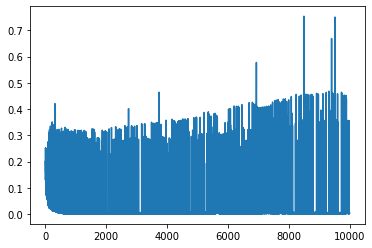

In [ ]:
## TD-learning with func approx

#setup
grid = GridWorldEnv()
agent = GridPlayer()
GAMMA = 0.9
ALPHA = 0.01

#here, agent plays a few rounds in the environment to sample possible states
agent.sample_unknown_environment(grid)

#approximate state values by linear function
agent.approximate_model('V')

#set a policy
agent.set_test_policy()
agent.visualise_policy()

#
mse_per_episode = []
for _ in range(10000):
  agent.reset_agent()
  Vs = agent.predictV(agent.CurrentState)
  n_steps = 0
  episode_err = 0

  while not grid.is_terminal(agent.CurrentState):

    #keep record of previous state
    agent.PreviousState = agent.CurrentState

    #get action
    action = agent.epsilon_greedy(agent.CurrentState) #action from current state (according to policy)
    
    #get next state, move & obtain reward
    next_state = grid.get_next_state(agent.CurrentState,action)
    agent.CurrentState = next_state
    reward = grid.get_reward(agent.CurrentState)
    
    # get target
    if grid.is_terminal(agent.CurrentState):
      target = reward
    else:
      Vs2 = agent.predictV(agent.CurrentState)
      target = reward + GAMMA* Vs2

    # update approximator in agent
    g = agent.gradientV(agent.PreviousState) #gradient is from previous state
    err = target - Vs
    agent.FuncWeights += ALPHA * err * g

    # accumulate error
    n_steps += 1
    episode_err += err**2

    # update value of state
    Vs = Vs2

  mse = episode_err/n_steps
  mse_per_episode.append(mse)


##
_ = plt.plot(mse_per_episode)

agent.approximate_values('V')
agent.visualise_values()

## Approximation methods for control

* We previously approximated $V(s)$, now we have to approximate $Q(s,a)$. We can do so similarly:
$$\text{let } x = \phi(s,a), \;\text{then }  \hat{Q}(s,a) = w^{T}x$$
* Note however that we have to keep track of actions now. As our actions are discrete, we can on-hot encode them, and concatenate them to the states, i.e
assuming our action space is $(\uparrow,\downarrow,\leftarrow,\rightarrow)$, if we were at state $(1,2)$ and moved $\downarrow$, then we can represent 
$$\hat{Q} \bigl((1,2),\downarrow \bigr) = \hat{Q}\bigl((1,2,0,1,0,0)\bigr)$$
* Once we've represented our state actions in a row, we can follow the same update rules:
$$J = \bigl( G -  \hat{Q}(s,a)\bigr)^{2}$$
$$\nabla_{w}J = -2(G-w^{T}x)x$$
$$w = w + \alpha(G-w^{T}x)x $$
* As a reminder, Q-learning target is
$$G = r + \gamma \max_{a'}\hat{Q}(s',a')$$


|<|<|^|+|
|<|#|v|-|
|<|^|^|<|

final values
| 0.62| 0.80| 1.00| 0.00|
| 0.46| 0.00| 0.78| 0.00|
| 0.31| 0.16| 0.04| 0.03|

final policy
|>|>|>|+|
|^|#|^|-|
|^|<|<|>|


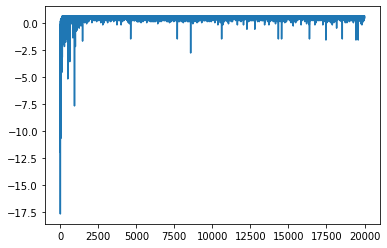

In [ ]:
## Q-learning with func approx - Control

#setup
grid = GridWorldEnv(step_cost=-.1)
agent = GridPlayer()
GAMMA = 0.9
ALPHA = 0.01

#here, agent plays a few rounds in the environment to sample possible states
agent.sample_unknown_environment(grid)

#approximate state values by linear function
agent.approximate_model('Q')

#set a policy
agent.set_equil_policy()
agent.visualise_policy()

#
reward_per_episode = []
for _ in range(20000):
  agent.reset_agent()
  agent.StateVisits[agent.CurrentState] += 1

  episode_reward = 0
  while not grid.is_terminal(agent.CurrentState):
    #keep record of previous state
    agent.PreviousState = agent.CurrentState

    #get action
    action = agent.epsilon_greedy(agent.CurrentState,'Q') #action from current state (according to policy)

    #get next state, move & obtain reward
    next_state = grid.get_next_state(agent.CurrentState,action)
    agent.CurrentState = next_state #move agent to new state
    reward = grid.get_reward(next_state)
    
    # get target
    if grid.is_terminal(agent.CurrentState):
      target = reward
    else:
      Qs2 = []
      for next_action in agent.ActionSpace:
        Qs2.append(agent.predictQ(agent.CurrentState,next_action)) #this is a list of all values of Q(s',a')
      target = reward + GAMMA* max(Qs2)

    # update approximator in agent
    g = agent.gradientQ(agent.PreviousState,action) #gradient is from previous state & action
    err = target - agent.predictQ(agent.PreviousState,action)
    agent.FuncWeights += ALPHA * err * g

    # accumulate reward & state visit counts
    episode_reward += reward
    agent.StateVisits[agent.CurrentState] += 1

  reward_per_episode.append(episode_reward)

#here, we should have obtained Q*. Now, set policy according to Q*
policy_dict = {s:{a:0 for a in agent.ActionSpace} for s in [(i,j) for i in range(agent.AvailRows) for j in range(agent.AvailCols)]}
for state in agent.AvailableStates:
  values = []
  maxQ = float('-inf')
  for action in agent.ActionSpace:
    Qs = agent.predictQ(state,action)
    values.append((action,Qs))
    maxQ = max(Qs,maxQ)
  
  max_a = []
  for act,val in values:
    if val == maxQ:
      max_a.append(act)
  policy_dict[state][np.random.choice(max_a)] = 1
agent.Policy = policy_dict 

##
_ = plt.plot(reward_per_episode)

agent.approximate_values('Q')
print('\nfinal values')
agent.visualise_values()
print('\nfinal policy')
agent.visualise_policy()